# libraries

In [ ]:
!pip install qnm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for qnm: filename=qnm-0.4.3-py3-none-any.whl size=95041 sha256=80479f07b9d4a5d8a1a059e46d1ef1ea2f5fd1b3ab6ad5f74c09969eac8c4044
  Stored in directory: /root/.cache/pip/wheels/4e/59/56/7efc566d098d0136aedc92657a4f7d9099b866ae55f29c1788
Successfully built qnm


In [ ]:
# libraries
import os
import re
import time
import copy
import qnm # https://arxiv.org/abs/1908.10377
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
dtype=torch.float32
torch.set_default_dtype(dtype)
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
from itertools import product
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, IterableDataset

# helpers

In [ ]:
class MyDataset(Dataset):
    def __init__(self):
        """
        dataset f(x)
        """
        self.x = None

    def __len__(self):
        return len(self.x[0])

    def __getitem__(self, idx):
        return self.x[idx]

    def get_full_item(self, idx):
        return self.x[idx][0], self.x[idx][1], self.x[idx][2], self.x[idx][3], self.x[idx][4], self.x[idx][5]

    def add_data_points(self, data):
        self.x = torch.from_numpy(data).type(dtype)

    def train_val_test_split(self):

        x_train, x_valtest, f_train, f_valtest = train_test_split(self.x[:, 0:1], self.x[:, 1:3], test_size=0.2, random_state=1234)
        x_val, x_test, f_val, f_test = train_test_split(x_valtest, f_valtest, test_size=0.5, random_state=1234)

        u_train, u_valtest, g_train, g_valtest = train_test_split(self.x[:, 3:4], self.x[:, 4:6], test_size=0.2, random_state=1234)
        u_val, u_test, g_val, g_test = train_test_split(u_valtest, g_valtest, test_size=0.5, random_state=1234)

        train = np.hstack((x_train, f_train[:, 0:1], f_train[:, 1:2], u_train, g_train[:, 0:1], g_train[:, 1:2]))
        val = np.hstack((x_val, f_val[:, 0:1], f_val[:, 1:2], u_val, g_val[:, 0:1], g_val[:, 1:2]))
        test = np.hstack((x_test, f_test[:, 0:1], f_test[:, 1:2], u_test, g_test[:, 0:1], g_test[:, 1:2]))

        return train, val, test

class Stan(torch.nn.Module):
    def __init__(self, D_hid):
        super().__init__()
        self.beta = torch.nn.Parameter(torch.ones(D_hid))
        self.output = D_hid

    def forward(self, x):
        if x.shape[-1] != self.beta.shape[-1]:
            raise ValueError(
                f"The last dimension of the input must be equal to the dimension of Stan parameters. Got inputs: {x.shape}, params: {self.beta.shape}"
            )
        return torch.tanh(x) * (torch.ones(self.output) + self.beta * x)

def dfx(x, f):
    return grad(f, x, grad_outputs=torch.ones(f.shape, dtype=dtype), create_graph=True)[0]


# pinns

In [ ]:
# physics-informed neural network

class kerr_pinn(torch.nn.Module):
    def __init__(self, D_hid):
        super(kerr_pinn,self).__init__()

        self.actF = Stan(D_hid)

        self.eigenvalues = torch.nn.Linear(4,4)
        self.Lin_1  = torch.nn.Linear(5, D_hid)
        self.Lin_2  = torch.nn.Linear(D_hid, D_hid)
        self.eigenfunctions = torch.nn.Linear(D_hid, 2)

    def forward(self, x, u):
        eigenvalues = self.eigenvalues(torch.cat((torch.abs(torch.ones_like(x)),
                                                   torch.abs(torch.ones_like(x)),
                                                   torch.abs(torch.ones_like(u)),
                                                   torch.zeros_like(u)), 1))

        L1 = self.Lin_1(torch.cat((x, eigenvalues), 1))
        h1 = self.actF(L1)
        L2 = self.Lin_2(h1)
        h2 = self.actF(L2)
        L3 = self.Lin_2(h2)
        h3 = self.actF(L3)
        f_ = self.eigenfunctions(h3)

        L_1 = self.Lin_1(torch.cat((u, eigenvalues), 1))
        h_1 = self.actF(L_1)
        L_2 = self.Lin_2(h_1)
        h_2 = self.actF(L_2)
        g_ = self.eigenfunctions(h_2)

        return f_, g_ , eigenvalues

#loss functions

In [ ]:
# loss functions

def kerr_loss_function(x, f1, f2, u, g1, g2, model, a, m, s):

    x = x.reshape(-1,1)
    x.requires_grad = True
    u = u.reshape(-1,1)
    u.requires_grad = True

    # PINN approximations

    f1_, f2_ = model(x, u)[0][:,0].reshape(-1,1), model(x, u)[0][:,1].reshape(-1,1)
    g1_, g2_ = model(x, u)[1][:,0].reshape(-1,1), model(x, u)[1][:,1].reshape(-1,1)
    omega1, omega2 = model(x, u)[2][:,0].reshape(-1,1), model(x, u)[2][:,1].reshape(-1,1)
    A1, A2 = model(x, u)[2][:,2].reshape(-1,1), model(x, u)[2][:,3].reshape(-1,1)

    # target data

    f = f1 + f2*1j
    g = g1 + g2*1j

    # derivatives

    f1_x, f2_x   = dfx(x, f1_), dfx(x, f2_)
    f1_xx, f2_xx = dfx(x, f1_x), dfx(x, f2_x)

    f_   = f1_ + f2_*1j
    f_x  = f1_x + f2_x*1j
    f_xx = f1_xx + f2_xx*1j

    g1_u, g2_u   = dfx(u, g1_), dfx(u, g2_)
    g1_uu, g2_uu = dfx(u, g1_u), dfx(u, g2_u)

    g_   = g1_ + g2_*1j
    g_u  = g1_u + g2_u*1j
    g_uu = g1_uu + g2_uu*1j

    # approximate QNMs

    omega = omega1.abs() - omega2.abs()*1j
    A = A1.abs() + A2.abs()*1j

    # radial

    r_p = (1 + ((1 - 4*(a**2))**(0.5)))/2
    F_0 = -(a**4)*(x**2)*(omega**2) - 2*(a**3)*m*(x**2)*omega + (a**2)*(-A*(x**2) + (x**2)*(4*(r_p + 1)*(omega**2) + 2*1j*(r_p + 2)*omega \
          + 2*1j*s*(omega + 1j) - 2) + x*(omega**2) - (omega**2)) + 2*a*m*(r_p*(x**2)*(2*omega + 1j) - x*(omega + 1j) - omega) + A*(x - 1) - 1j*r_p*(2*omega + 1j)*((x**2)*(s - 2*1j*omega + 1) - 2*(s + 1)*x + 2*1j*omega) + (s + 1)*(x - 2*1j*omega)
    F_1 = 2*(a**4)*(x**4)*(x - 1j*omega) - 2*1j*(a**3)*m*(x**4) + (a**2)*(x**2)*(2*r_p*(x**2)*(-1 + 2*1j*omega) - (s + 3)*(x**2) + 2*x*(s + 1j*omega + 2) - 4*1j*omega) + 2*1j*a*m*(x - 1)*(x**2) + (x - 1)*(2*r_p*(x**2)*(1 - 2*1j*omega) + (s + 1)*(x**2) - 2*(s + 1)*x + 2*1j*omega)
    F_2 = (a**4)*(x**6) - 2*(a**2)*(x - 1)*(x**4) + ((x - 1)**2)*(x**2)

    # angular

    G_0 = 4*(a**2)*((u**2) - 1)*(omega**2) - 4*a*((u**2) - 1)*omega*((u - 1)*abs(m - s) + (u + 1)*abs(m + s) + 2*(s + 1)*u) + 4*(A*((u**2) - 1) + (m**2) + 2*m*s*u + s*((s + 1)*(u**2) - 1)) - 2*((u**2) - 1)*abs(m + s) - 2*((u**2) - 1)*abs(m - s)*(abs(m + s) + 1) - ((u - 1)**2)*(abs(m - s)**2) - ((u + 1)**2)*(abs(m + s)**2)
    G_1 = -8*a*(((u**2) - 1)**2)*omega - 4*((u**2) - 1)*((u - 1)*abs(m - s) + (u + 1)*abs(m + s) + 2*u)
    G_2 = -4*(((u**2) - 1)**2)

    # ODE losses

    L_radial_ODE = torch.mean(((F_2*f_xx + F_1*f_x + F_0*f_).abs())**2)
    L_angular_ODE = torch.mean(((G_2*g_uu + G_1*g_u + G_0*g_).abs())**2)

    # mean-square error loss crucial part of supervised-learning:
    L_MSE = torch.mean(((f - f_).abs())**2) + torch.mean(((g - g_).abs())**2)

    Loss = L_radial_ODE + L_angular_ODE + L_MSE

    return Loss, L_MSE, omega1, omega2, A1, A2


#training loop

In [ ]:
# training loop

def run_eigenvalue_solver(dataset, a, ell, m, n, s, epsilon, neurons, epochs, learning_rate, omega, A, metric="kerr"):

    train_loss, val_loss, omega1, omega2, err1, err2, A1, A2, err3, err4 = [], [], [], [], [], [], [], [], [], []

    start_time = time.time()

    print("targets: omega: %.6f - %.6f i; A: %.6f + %.6f i\n" %(abs(omega.real),
                                                                abs(omega.imag),
                                                                abs(A.real),
                                                                abs(A.imag)))

    # load data

    radial_and_angular_data = MyDataset()

    radial_and_angular_data.add_data_points(dataset)

    train_data, val_data, test_data = radial_and_angular_data.train_val_test_split()

    # example f(x = x_0) and g(u = u_0)

    x_0, f1_x0, f2_x0, u_0, g1_u0, g2_u0 = radial_and_angular_data.get_full_item(0)

    print("\n f(x = x_0) and g(u = u_0);\n f(x = %.3f) = (%.3f, %.3f);\n g(u = %.3f) = (%.3f, %.3f);\n"
          %(x_0, f1_x0, f2_x0, u_0, g1_u0, g2_u0))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    batch_size = 32

    train_dataloader = DataLoader(dataset = train_data, shuffle = True, batch_size = batch_size, num_workers = 0)

    val_dataloader = DataLoader(dataset = val_data, shuffle = True, batch_size = batch_size, num_workers = 0)

    test_dataloader = DataLoader(dataset = test_data, shuffle = True, batch_size = batch_size, num_workers = 0)

    model = kerr_pinn(neurons)
    betas = [0.999, 0.9999]
    optimiser = optim.Adam(model.parameters(), lr=learning_rate, betas = betas)

    start_time = time.time()

    for epoch in tqdm(range(epochs), leave=False):

        running_train_loss = 0.0
        running_val_loss = 0.0

        model.train()
        for data in train_dataloader:
            model.zero_grad()
            optimiser.zero_grad()

            x, f1, f2, u, g1, g2 = data[:,0:1], data[:,1:2], data[:,2:3], data[:,3:4], data[:,4:5], data[:,5:6]

            L_total, L_MSE, omega1_, omega2_, A1_, A2_ = kerr_loss_function(x, f1, f2, u, g1, g2, model, a, m, s)

            L_total.backward(retain_graph = False);
            optimiser.step()
            optimiser.zero_grad()

            omega1.append(abs(omega1_[0].data.tolist()[0]))
            omega2.append(abs(omega2_[0].data.tolist()[0]))
            err1_ = (((abs(omega1_) - abs(omega.real))/abs(omega.real))*100).mean()
            err2_ = (((abs(omega2_) - abs(omega.imag))/abs(omega.imag))*100).mean()
            err1.append(err1_.data.tolist())
            err2.append(err2_.data.tolist())

            A1.append(abs(A1_[0].data.tolist()[0]))
            A2.append(abs(A2_[0].data.tolist()[0]))
            err3_ = (((abs(A1_) - abs(A.real))/abs(A.real))*100).mean()
            err4_ = ((((abs(A2_) + 1) - abs(A.imag + 1))/abs(A.imag + 1))*100).mean()
            err3.append(err3_.data.tolist())
            err4.append(err4_.data.tolist())

            running_train_loss += L_MSE.data.numpy() * data.size(0)

        model.eval()
        for data in val_dataloader:

            x, f1, f2, u, g1, g2 = data[:,0:1], data[:,1:2], data[:,2:3], data[:,3:4], data[:,4:5], data[:,5:6]
            f = f1 + f2*1j
            g = g1 + g2*1j

            x = x.reshape(-1,1)
            x.requires_grad = False
            u = u.reshape(-1,1)
            u.requires_grad = False
            f1_, f2_ = model(x, u)[0][:,0].reshape(-1,1), model(x, u)[0][:,1].reshape(-1,1)
            g1_, g2_ = model(x, u)[1][:,0].reshape(-1,1), model(x, u)[1][:,1].reshape(-1,1)
            f_ = f1_ + f2_*1j
            g_ = g1_ + g2_*1j

            L_MSE = torch.mean(((f - f_).abs())**2) + torch.mean(((g - g_).abs())**2)

            running_val_loss += L_MSE.data.numpy() * data.size(0)

        avg_train_loss = running_train_loss / len(train_dataloader.dataset)
        avg_val_loss = running_val_loss / len(test_dataloader.dataset)

        train_loss.append(avg_train_loss)
        val_loss.append(avg_val_loss)

        if epoch % 100 == 0 and epoch > 0:
            print('train loss: %.8f , val loss: %.8f; omega: %.8f %.8f i. error: %.4f , %.4f . A: %.8f %.8f i. error: %.4f , %.4f .'
            %(avg_train_loss,
              avg_val_loss,
              omega1[-1], omega2[-1],
              err1[-1], err2[-1],
              A1[-1], A2[-1],
              err3[-1], err4[-1]))


    end_time = time.time()
    runtime = end_time - start_time

    # test

    model.eval()
    for data in test_dataloader:

        x, f1, f2, u, g1, g2 = data[:,0:1], data[:,1:2], data[:,2:3], data[:,3:4], data[:,4:5], data[:,5:6]
        f = f1 + f2*1j
        g = g1 + g2*1j

        x = x.reshape(-1,1)
        x.requires_grad = False
        u = u.reshape(-1,1)
        u.requires_grad = False
        f1_, f2_ = model(x, u)[0][:,0].reshape(-1,1), model(x, u)[0][:,1].reshape(-1,1)
        g1_, g2_ = model(x, u)[1][:,0].reshape(-1,1), model(x, u)[1][:,1].reshape(-1,1)
        f_ = f1_ + f2_*1j
        g_ = g1_ + g2_*1j

        deltaf = (torch.sqrt(torch.mean(((f - f_).abs())**2)) / torch.sqrt(torch.mean(((f).abs())**2)))
        deltag = (torch.sqrt(torch.mean(((g - g_).abs())**2)) / torch.sqrt(torch.mean(((g).abs())**2)))

        RMSE = (deltaf + deltag)/2

        acc = (1 - RMSE)*100

    approx_hists = (train_loss, val_loss, omega1, omega2, err1, err2, A1, A2, err3, err4, acc)

    return approx_hists, runtime

# run training

In [ ]:
### run main process

from google.colab import drive
drive.mount('/content/gdrive')

metric = "kerr"

neurons, epochs, learning_rate = 20, int(5e3), 2e-3

s = -2
a = [0.1]
ell = [2.0]
m = [2.0]
n = [1.0, 2.0, 3.0, 4.0, 5.0]

mode = [dict(zip(["a", "ell", "m", "n"], [i, j, k, l])) for i, j, k, l in product(a, ell, m, n)]

train_loss_dict, val_loss_dict, omega1_dict, omega2_dict, err1_dict, err2_dict = dict(), dict(), dict(), dict(), dict(), dict()
A1_dict, A2_dict, err3_dict, err4_dict, acc_dict, runtime_dict =  dict(), dict(), dict(), dict(), dict(), dict()

for i in range(len(mode)):

    a = mode[i]["a"]
    ell = mode[i]["ell"]
    m = mode[i]["m"]
    n = mode[i]["n"]

    print("\nspin sequence: s=%s, a=%s, ell=%s, m=%s, n=%s" %(s, a, ell, m, n))

    radial_component = ['R_a%sell%sm%sn%s.csv'%(a, ell, m, n)]
    radial_component = [np.loadtxt('gdrive/MyDrive/qnm_data_updated/'+f,delimiter=',') for f in radial_component]

    spheroidal_harmonics = ['S_a%sell%sm%sn%s.csv'%(a, ell, m, n)]
    spheroidal_harmonics = [np.loadtxt('gdrive/MyDrive/qnm_data_updated/'+f,delimiter=',') for f in spheroidal_harmonics]
    np.random.shuffle(spheroidal_harmonics[0])

    # balancing data

    balance = min(len(spheroidal_harmonics[0]), len(radial_component[0]))

    radial_component[0] = radial_component[0][0:balance]

    spheroidal_harmonics[0] = spheroidal_harmonics[0][0:balance]

    print("\nsize of radial data %.0f; size of angular data %.0f"%(len(radial_component[0]),len(spheroidal_harmonics[0])))

    # concatenate data

    dataset = np.concatenate((radial_component[0], spheroidal_harmonics[0]), axis=1)

    # QNMs from https://arxiv.org/abs/1908.10377

    spin_sequence_slmn = qnm.modes_cache(s=int(s), l=int(ell), m=int(m), n=int(n))
    omega_, A_, _ = spin_sequence_slmn(a=a*2)

    omega = abs(float(omega_.real)*2) - abs(float(omega_.imag)*2)*1j
    A = abs(float(A_.real)) + abs(float(A_.imag))*1j

    # training

    approx_hists, runtime = run_eigenvalue_solver(dataset,
                                                  a, ell, m, n , s,
                                                  None,
                                                  neurons, epochs, learning_rate,
                                                  omega, A, metric)

    print("\nruntime: %.0f minutes" %(runtime/60))

    train_loss_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[0]})
    val_loss_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[1]})
    omega1_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[2]})
    omega2_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[3]})
    err1_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[4]})
    err2_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[5]})
    A1_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[6]})
    A2_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[7]})
    err3_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[8]})
    err4_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[9]})
    acc_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[10]})
    runtime_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): runtime})

Mounted at /content/gdrive

spin sequence: s=-2, a=0.1, ell=2.0, m=2.0, n=1.0

size of radial data 900; size of angular data 900
targets: omega: 0.757953 - 0.541091 i; A: 3.795821 + 0.150369 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (0.728, 0.774);
 g(u = 0.614) = (0.960, 0.027);



  2%|▏         | 101/5000 [00:58<43:05,  1.89it/s]

train loss: 0.06807980 , val loss: 0.07220989; omega: 0.74719208 0.39247665 i. error: -1.4197 , -27.4657 . A: 3.92061615 0.06982255 i. error: 3.2877 , -7.0018 .


  4%|▍         | 201/5000 [01:57<53:54,  1.48it/s]

train loss: 0.00776676 , val loss: 0.00753591; omega: 0.84581012 0.49624169 i. error: 11.5914 , -8.2887 . A: 3.70009851 0.13246077 i. error: -2.5218 , -1.5567 .


  6%|▌         | 301/5000 [02:55<42:01,  1.86it/s]

train loss: 0.00051808 , val loss: 0.00031541; omega: 0.75421083 0.55332583 i. error: -0.4937 , 2.2611 . A: 3.82058144 0.15489140 i. error: 0.6523 , 0.3931 .


  8%|▊         | 401/5000 [03:53<40:36,  1.89it/s]

train loss: 0.00007062 , val loss: 0.00004901; omega: 0.76702857 0.54947871 i. error: 1.1974 , 1.5501 . A: 3.79796600 0.14471456 i. error: 0.0565 , -0.4915 .


 10%|█         | 501/5000 [04:52<54:01,  1.39it/s]

train loss: 0.00003562 , val loss: 0.00003026; omega: 0.76699084 0.54747599 i. error: 1.1924 , 1.1800 . A: 3.79489779 0.14977354 i. error: -0.0243 , -0.0517 .


 12%|█▏        | 601/5000 [05:49<40:14,  1.82it/s]

train loss: 0.00002243 , val loss: 0.00001981; omega: 0.76659906 0.54557103 i. error: 1.1408 , 0.8279 . A: 3.79653883 0.14870870 i. error: 0.0189 , -0.1443 .


 14%|█▍        | 701/5000 [06:46<37:20,  1.92it/s]

train loss: 0.00001773 , val loss: 0.00001519; omega: 0.76583028 0.54539752 i. error: 1.0393 , 0.7959 . A: 3.79524827 0.14907905 i. error: -0.0151 , -0.1121 .


 16%|█▌        | 801/5000 [07:45<49:26,  1.42it/s]

train loss: 0.00001092 , val loss: 0.00000950; omega: 0.76498783 0.54507089 i. error: 0.9282 , 0.7355 . A: 3.79480600 0.14912271 i. error: -0.0267 , -0.1083 .


 18%|█▊        | 901/5000 [08:43<38:20,  1.78it/s]

train loss: 0.00000588 , val loss: 0.00000540; omega: 0.76413578 0.54480290 i. error: 0.8158 , 0.6860 . A: 3.79523754 0.14938742 i. error: -0.0154 , -0.0853 .


 20%|██        | 1001/5000 [09:39<34:28,  1.93it/s]

train loss: 0.00000331 , val loss: 0.00000261; omega: 0.76350331 0.54462689 i. error: 0.7323 , 0.6534 . A: 3.79582405 0.14931658 i. error: 0.0001 , -0.0915 .


 22%|██▏       | 1101/5000 [10:35<33:44,  1.93it/s]

train loss: 0.00000155 , val loss: 0.00000145; omega: 0.76303506 0.54440200 i. error: 0.6705 , 0.6119 . A: 3.79610467 0.14924085 i. error: 0.0075 , -0.0981 .


 24%|██▍       | 1201/5000 [11:33<39:25,  1.61it/s]

train loss: 0.00000172 , val loss: 0.00000160; omega: 0.76264894 0.54409492 i. error: 0.6196 , 0.5551 . A: 3.79609299 0.14917859 i. error: 0.0072 , -0.1035 .


 26%|██▌       | 1301/5000 [12:29<32:31,  1.90it/s]

train loss: 0.00000154 , val loss: 0.00000153; omega: 0.76253879 0.54399085 i. error: 0.6051 , 0.5359 . A: 3.79594278 0.14909607 i. error: 0.0032 , -0.1106 .


 28%|██▊       | 1401/5000 [13:25<31:05,  1.93it/s]

train loss: 0.00000174 , val loss: 0.00000167; omega: 0.76258993 0.54369676 i. error: 0.6118 , 0.4815 . A: 3.79571152 0.14913282 i. error: -0.0029 , -0.1074 .


 30%|███       | 1501/5000 [14:23<41:12,  1.42it/s]

train loss: 0.00000184 , val loss: 0.00000173; omega: 0.76266849 0.54354739 i. error: 0.6222 , 0.4539 . A: 3.79570675 0.14915240 i. error: -0.0030 , -0.1057 .


 32%|███▏      | 1601/5000 [15:20<30:53,  1.83it/s]

train loss: 0.00000232 , val loss: 0.00000213; omega: 0.76280314 0.54350615 i. error: 0.6399 , 0.4463 . A: 3.79562807 0.14915556 i. error: -0.0051 , -0.1055 .


 34%|███▍      | 1701/5000 [16:17<29:05,  1.89it/s]

train loss: 0.00000358 , val loss: 0.00000366; omega: 0.76277751 0.54337966 i. error: 0.6366 , 0.4229 . A: 3.79519582 0.14943692 i. error: -0.0165 , -0.0810 .


 36%|███▌      | 1801/5000 [17:14<37:37,  1.42it/s]

train loss: 0.00000253 , val loss: 0.00000269; omega: 0.76266372 0.54309356 i. error: 0.6215 , 0.3701 . A: 3.79535294 0.14950246 i. error: -0.0123 , -0.0753 .


 38%|███▊      | 1901/5000 [18:12<27:50,  1.86it/s]

train loss: 0.00000236 , val loss: 0.00000258; omega: 0.76268768 0.54328811 i. error: 0.6247 , 0.4060 . A: 3.79521465 0.14971250 i. error: -0.0160 , -0.0570 .


 40%|████      | 2001/5000 [19:09<26:55,  1.86it/s]

train loss: 0.00000228 , val loss: 0.00000228; omega: 0.76262879 0.54312396 i. error: 0.6169 , 0.3757 . A: 3.79522634 0.14985219 i. error: -0.0157 , -0.0449 .


 42%|████▏     | 2101/5000 [20:07<33:53,  1.43it/s]

train loss: 0.00000253 , val loss: 0.00000248; omega: 0.76278102 0.54299802 i. error: 0.6370 , 0.3524 . A: 3.79509449 0.14995354 i. error: -0.0191 , -0.0361 .


 44%|████▍     | 2201/5000 [21:04<25:06,  1.86it/s]

train loss: 0.00000438 , val loss: 0.00000383; omega: 0.76296043 0.54294705 i. error: 0.6607 , 0.3430 . A: 3.79468536 0.14996400 i. error: -0.0299 , -0.0352 .


 46%|████▌     | 2301/5000 [22:01<23:40,  1.90it/s]

train loss: 0.00000455 , val loss: 0.00000574; omega: 0.76266897 0.54354215 i. error: 0.6222 , 0.4530 . A: 3.79493999 0.15017125 i. error: -0.0232 , -0.0172 .


 48%|████▊     | 2401/5000 [22:59<29:46,  1.45it/s]

train loss: 0.00000339 , val loss: 0.00000275; omega: 0.76295626 0.54317892 i. error: 0.6601 , 0.3858 . A: 3.79537416 0.14918786 i. error: -0.0118 , -0.1027 .


 50%|█████     | 2501/5000 [23:56<22:28,  1.85it/s]

train loss: 0.00000333 , val loss: 0.00000367; omega: 0.76284158 0.54328746 i. error: 0.6450 , 0.4059 . A: 3.79542780 0.14942649 i. error: -0.0104 , -0.0819 .


 52%|█████▏    | 2601/5000 [24:53<20:48,  1.92it/s]

train loss: 0.00000308 , val loss: 0.00000290; omega: 0.76278532 0.54316080 i. error: 0.6376 , 0.3825 . A: 3.79506636 0.15042114 i. error: -0.0199 , 0.0045 .


 54%|█████▍    | 2701/5000 [25:50<27:51,  1.38it/s]

train loss: 0.00000258 , val loss: 0.00000216; omega: 0.76260936 0.54310155 i. error: 0.6144 , 0.3715 . A: 3.79522324 0.15015274 i. error: -0.0157 , -0.0188 .


 56%|█████▌    | 2801/5000 [26:49<19:27,  1.88it/s]

train loss: 0.00000259 , val loss: 0.00000211; omega: 0.76270437 0.54312170 i. error: 0.6269 , 0.3753 . A: 3.79513836 0.15044075 i. error: -0.0180 , 0.0062 .


 58%|█████▊    | 2901/5000 [27:45<18:07,  1.93it/s]

train loss: 0.00000318 , val loss: 0.00000244; omega: 0.76257020 0.54303777 i. error: 0.6092 , 0.3597 . A: 3.79518557 0.15035605 i. error: -0.0167 , -0.0011 .


 60%|██████    | 3001/5000 [28:44<23:27,  1.42it/s]

train loss: 0.00000312 , val loss: 0.00000224; omega: 0.76285267 0.54314804 i. error: 0.6465 , 0.3801 . A: 3.79503393 0.15049314 i. error: -0.0207 , 0.0108 .


 62%|██████▏   | 3101/5000 [29:41<16:56,  1.87it/s]

train loss: 0.00000273 , val loss: 0.00000235; omega: 0.76272672 0.54317313 i. error: 0.6299 , 0.3848 . A: 3.79520321 0.15060091 i. error: -0.0163 , 0.0202 .


 64%|██████▍   | 3201/5000 [30:37<15:55,  1.88it/s]

train loss: 0.00000238 , val loss: 0.00000209; omega: 0.76260692 0.54314935 i. error: 0.6141 , 0.3804 . A: 3.79499745 0.15060225 i. error: -0.0217 , 0.0203 .


 66%|██████▌   | 3301/5000 [31:36<18:56,  1.50it/s]

train loss: 0.00000232 , val loss: 0.00000199; omega: 0.76269376 0.54307872 i. error: 0.6255 , 0.3673 . A: 3.79510212 0.15064526 i. error: -0.0189 , 0.0240 .


 68%|██████▊   | 3401/5000 [32:33<14:25,  1.85it/s]

train loss: 0.00000431 , val loss: 0.00000302; omega: 0.76244318 0.54337782 i. error: 0.5925 , 0.4226 . A: 3.79512644 0.15072230 i. error: -0.0183 , 0.0307 .


 70%|███████   | 3501/5000 [33:29<13:02,  1.92it/s]

train loss: 0.00000326 , val loss: 0.00000306; omega: 0.76260751 0.54302037 i. error: 0.6141 , 0.3565 . A: 3.79509354 0.15080354 i. error: -0.0192 , 0.0378 .


 72%|███████▏  | 3601/5000 [34:27<16:49,  1.39it/s]

train loss: 0.00000343 , val loss: 0.00000608; omega: 0.76269555 0.54302967 i. error: 0.6257 , 0.3583 . A: 3.79503727 0.15091041 i. error: -0.0206 , 0.0471 .


 74%|███████▍  | 3701/5000 [35:24<11:38,  1.86it/s]

train loss: 0.00001428 , val loss: 0.00003371; omega: 0.76254427 0.54254806 i. error: 0.6058 , 0.2692 . A: 3.79518890 0.15102741 i. error: -0.0166 , 0.0573 .


 76%|███████▌  | 3801/5000 [36:20<10:19,  1.94it/s]

train loss: 0.00000517 , val loss: 0.00000602; omega: 0.76264024 0.54343939 i. error: 0.6184 , 0.4340 . A: 3.79426861 0.15107438 i. error: -0.0409 , 0.0613 .


 78%|███████▊  | 3901/5000 [37:18<12:36,  1.45it/s]

train loss: 0.00001281 , val loss: 0.00000292; omega: 0.76277775 0.54243261 i. error: 0.6366 , 0.2479 . A: 3.79473591 0.15064445 i. error: -0.0286 , 0.0240 .


 80%|████████  | 4001/5000 [38:15<08:51,  1.88it/s]

train loss: 0.00000563 , val loss: 0.00000931; omega: 0.76286721 0.54276592 i. error: 0.6484 , 0.3095 . A: 3.79430389 0.15049258 i. error: -0.0400 , 0.0108 .


 82%|████████▏ | 4101/5000 [39:12<07:52,  1.90it/s]

train loss: 0.00000397 , val loss: 0.00000335; omega: 0.76289546 0.54323781 i. error: 0.6521 , 0.3967 . A: 3.79522467 0.15065926 i. error: -0.0157 , 0.0253 .


 84%|████████▍ | 4201/5000 [40:10<09:14,  1.44it/s]

train loss: 0.00000902 , val loss: 0.00001556; omega: 0.76250911 0.54291022 i. error: 0.6011 , 0.3362 . A: 3.79489565 0.15080538 i. error: -0.0244 , 0.0379 .


 86%|████████▌ | 4301/5000 [41:07<06:19,  1.84it/s]

train loss: 0.00000700 , val loss: 0.00000812; omega: 0.76258397 0.54260910 i. error: 0.6110 , 0.2805 . A: 3.79476929 0.15029135 i. error: -0.0277 , -0.0067 .


 88%|████████▊ | 4401/5000 [42:04<05:15,  1.90it/s]

train loss: 0.00000244 , val loss: 0.00000223; omega: 0.76274633 0.54311484 i. error: 0.6324 , 0.3740 . A: 3.79495049 0.15082759 i. error: -0.0229 , 0.0399 .


 90%|█████████ | 4501/5000 [43:02<05:47,  1.44it/s]

train loss: 0.00000236 , val loss: 0.00000238; omega: 0.76269078 0.54332912 i. error: 0.6251 , 0.4136 . A: 3.79510307 0.15093917 i. error: -0.0189 , 0.0496 .


 92%|█████████▏| 4601/5000 [43:59<03:38,  1.83it/s]

train loss: 0.00000286 , val loss: 0.00000224; omega: 0.76252925 0.54343140 i. error: 0.6038 , 0.4325 . A: 3.79446983 0.15050390 i. error: -0.0356 , 0.0117 .


 94%|█████████▍| 4701/5000 [44:56<02:39,  1.87it/s]

train loss: 0.00000734 , val loss: 0.00000414; omega: 0.76256359 0.54332221 i. error: 0.6083 , 0.4123 . A: 3.79533577 0.15080294 i. error: -0.0128 , 0.0377 .


 96%|█████████▌| 4801/5000 [45:54<02:16,  1.46it/s]

train loss: 0.00000348 , val loss: 0.00000225; omega: 0.76223207 0.54315186 i. error: 0.5646 , 0.3808 . A: 3.79492426 0.15080929 i. error: -0.0236 , 0.0383 .


 98%|█████████▊| 4901/5000 [46:51<00:53,  1.84it/s]

train loss: 0.00000616 , val loss: 0.00001108; omega: 0.76263320 0.54300821 i. error: 0.6175 , 0.3543 . A: 3.79532051 0.15096441 i. error: -0.0132 , 0.0518 .



runtime: 48 minutes

spin sequence: s=-2, a=0.1, ell=2.0, m=2.0, n=2.0

size of radial data 900; size of angular data 900
targets: omega: 0.678570 - 0.935744 i; A: 3.822187 + 0.258900 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (-1.479, 3.288);
 g(u = 0.599) = (0.963, 0.047);



  2%|▏         | 101/5000 [00:58<58:24,  1.40it/s]

train loss: 0.03676979 , val loss: 0.03567619; omega: 0.78209919 0.95289040 i. error: 15.2569 , 1.8324 . A: 4.07888889 0.07351516 i. error: 6.7161 , -14.7259 .


  4%|▍         | 201/5000 [01:56<42:15,  1.89it/s]

train loss: 0.00241009 , val loss: 0.00197251; omega: 0.69138741 0.93401945 i. error: 1.8888 , -0.1843 . A: 3.81595087 0.24073623 i. error: -0.1632 , -1.4428 .


  6%|▌         | 301/5000 [02:53<40:46,  1.92it/s]

train loss: 0.00061102 , val loss: 0.00055204; omega: 0.68552423 0.94836920 i. error: 1.0248 , 1.3492 . A: 3.80938101 0.26095441 i. error: -0.3350 , 0.1632 .


  8%|▊         | 401/5000 [03:51<47:46,  1.60it/s]

train loss: 0.00032078 , val loss: 0.00020776; omega: 0.68584466 0.95017529 i. error: 1.0720 , 1.5422 . A: 3.81197858 0.26394847 i. error: -0.2671 , 0.4010 .


 10%|█         | 501/5000 [04:48<39:21,  1.90it/s]

train loss: 0.00008899 , val loss: 0.00005475; omega: 0.68540359 0.94617254 i. error: 1.0070 , 1.1144 . A: 3.81462669 0.26392999 i. error: -0.1978 , 0.3996 .


 12%|█▏        | 601/5000 [05:45<38:32,  1.90it/s]

train loss: 0.00004209 , val loss: 0.00005147; omega: 0.68666357 0.94635010 i. error: 1.1927 , 1.1334 . A: 3.81646514 0.26496401 i. error: -0.1497 , 0.4817 .


 14%|█▍        | 701/5000 [06:43<45:37,  1.57it/s]

train loss: 0.00003459 , val loss: 0.00003093; omega: 0.68711007 0.94543302 i. error: 1.2585 , 1.0354 . A: 3.81801891 0.26444289 i. error: -0.1091 , 0.4403 .


 16%|█▌        | 801/5000 [07:40<36:30,  1.92it/s]

train loss: 0.00002872 , val loss: 0.00002470; omega: 0.68723726 0.94559115 i. error: 1.2772 , 1.0523 . A: 3.81820536 0.26352501 i. error: -0.1042 , 0.3674 .


 18%|█▊        | 901/5000 [08:37<36:06,  1.89it/s]

train loss: 0.00002514 , val loss: 0.00002225; omega: 0.68716884 0.94568002 i. error: 1.2672 , 1.0618 . A: 3.81828618 0.26302364 i. error: -0.1021 , 0.3276 .


 20%|██        | 1001/5000 [09:35<40:59,  1.63it/s]

train loss: 0.00002785 , val loss: 0.00003109; omega: 0.68716455 0.94568753 i. error: 1.2665 , 1.0626 . A: 3.81846952 0.26252890 i. error: -0.0973 , 0.2883 .


 22%|██▏       | 1101/5000 [10:32<34:25,  1.89it/s]

train loss: 0.00002812 , val loss: 0.00003453; omega: 0.68701613 0.94542617 i. error: 1.2447 , 1.0347 . A: 3.81859279 0.26218534 i. error: -0.0940 , 0.2610 .


 24%|██▍       | 1201/5000 [11:31<42:47,  1.48it/s]

train loss: 0.00002263 , val loss: 0.00002028; omega: 0.68704247 0.94553852 i. error: 1.2485 , 1.0467 . A: 3.81881142 0.26202193 i. error: -0.0883 , 0.2480 .


 26%|██▌       | 1301/5000 [12:29<33:59,  1.81it/s]

train loss: 0.00002202 , val loss: 0.00002322; omega: 0.68696463 0.94558275 i. error: 1.2371 , 1.0514 . A: 3.81869388 0.26195279 i. error: -0.0914 , 0.2425 .


 28%|██▊       | 1401/5000 [13:26<31:26,  1.91it/s]

train loss: 0.00002901 , val loss: 0.00003740; omega: 0.68709463 0.94565457 i. error: 1.2562 , 1.0591 . A: 3.81866431 0.26192409 i. error: -0.0922 , 0.2402 .


 30%|███       | 1501/5000 [14:25<41:18,  1.41it/s]

train loss: 0.00002160 , val loss: 0.00002035; omega: 0.68694627 0.94546580 i. error: 1.2344 , 1.0389 . A: 3.81880331 0.26176050 i. error: -0.0885 , 0.2272 .


 32%|███▏      | 1601/5000 [15:22<30:13,  1.87it/s]

train loss: 0.00002309 , val loss: 0.00002999; omega: 0.68670040 0.94566005 i. error: 1.1981 , 1.0597 . A: 3.81905532 0.26190552 i. error: -0.0819 , 0.2388 .


 34%|███▍      | 1701/5000 [16:20<29:17,  1.88it/s]

train loss: 0.00002520 , val loss: 0.00001842; omega: 0.68694764 0.94557655 i. error: 1.2346 , 1.0507 . A: 3.81899476 0.26212201 i. error: -0.0835 , 0.2560 .


 36%|███▌      | 1801/5000 [17:19<31:13,  1.71it/s]

train loss: 0.00002116 , val loss: 0.00002536; omega: 0.68672895 0.94541061 i. error: 1.2023 , 1.0330 . A: 3.81898808 0.26217911 i. error: -0.0837 , 0.2605 .


 38%|███▊      | 1901/5000 [18:16<27:07,  1.90it/s]

train loss: 0.00002422 , val loss: 0.00002126; omega: 0.68687820 0.94534701 i. error: 1.2243 , 1.0262 . A: 3.81889439 0.26212573 i. error: -0.0861 , 0.2563 .


 40%|████      | 2001/5000 [19:14<34:57,  1.43it/s]

train loss: 0.00003490 , val loss: 0.00002615; omega: 0.68694109 0.94541711 i. error: 1.2336 , 1.0337 . A: 3.81925368 0.26207966 i. error: -0.0767 , 0.2526 .


 42%|████▏     | 2101/5000 [20:12<26:23,  1.83it/s]

train loss: 0.00003482 , val loss: 0.00003789; omega: 0.68694389 0.94505280 i. error: 1.2340 , 0.9948 . A: 3.81918192 0.26218727 i. error: -0.0786 , 0.2611 .


 44%|████▍     | 2201/5000 [21:09<25:02,  1.86it/s]

train loss: 0.00002335 , val loss: 0.00001990; omega: 0.68680596 0.94496387 i. error: 1.2137 , 0.9853 . A: 3.81952715 0.26198378 i. error: -0.0696 , 0.2450 .


 46%|████▌     | 2301/5000 [22:07<33:47,  1.33it/s]

train loss: 0.00002370 , val loss: 0.00002148; omega: 0.68672484 0.94499952 i. error: 1.2017 , 0.9891 . A: 3.81962109 0.26229128 i. error: -0.0671 , 0.2694 .


 48%|████▊     | 2401/5000 [23:04<22:50,  1.90it/s]

train loss: 0.00003628 , val loss: 0.00005571; omega: 0.68645728 0.94559681 i. error: 1.1623 , 1.0529 . A: 3.82000494 0.26268825 i. error: -0.0571 , 0.3009 .


 50%|█████     | 2501/5000 [24:02<21:54,  1.90it/s]

train loss: 0.00004199 , val loss: 0.00003717; omega: 0.68706816 0.94506925 i. error: 1.2523 , 0.9965 . A: 3.81942844 0.26343083 i. error: -0.0722 , 0.3599 .


 52%|█████▏    | 2601/5000 [25:00<26:14,  1.52it/s]

train loss: 0.00003421 , val loss: 0.00003537; omega: 0.68652654 0.94508898 i. error: 1.1725 , 0.9986 . A: 3.82039237 0.26255766 i. error: -0.0470 , 0.2906 .


 54%|█████▍    | 2701/5000 [25:56<20:21,  1.88it/s]

train loss: 0.00003405 , val loss: 0.00001751; omega: 0.68687850 0.94481683 i. error: 1.2244 , 0.9696 . A: 3.82023382 0.26285917 i. error: -0.0511 , 0.3145 .


 56%|█████▌    | 2801/5000 [26:53<19:18,  1.90it/s]

train loss: 0.00003343 , val loss: 0.00003153; omega: 0.68692482 0.94510591 i. error: 1.2312 , 1.0005 . A: 3.82040238 0.26205236 i. error: -0.0467 , 0.2504 .


 58%|█████▊    | 2901/5000 [27:52<21:47,  1.61it/s]

train loss: 0.00002410 , val loss: 0.00002395; omega: 0.68659854 0.94477302 i. error: 1.1831 , 0.9649 . A: 3.82004189 0.26271015 i. error: -0.0561 , 0.3027 .


 60%|██████    | 3001/5000 [28:49<17:44,  1.88it/s]

train loss: 0.00002787 , val loss: 0.00002744; omega: 0.68683344 0.94530165 i. error: 1.2177 , 1.0214 . A: 3.82015347 0.26231387 i. error: -0.0532 , 0.2712 .


 62%|██████▏   | 3101/5000 [29:46<16:35,  1.91it/s]

train loss: 0.00002144 , val loss: 0.00002510; omega: 0.68653756 0.94507080 i. error: 1.1741 , 0.9967 . A: 3.82008386 0.26261377 i. error: -0.0550 , 0.2950 .


 64%|██████▍   | 3201/5000 [30:44<17:45,  1.69it/s]

train loss: 0.00003460 , val loss: 0.00004335; omega: 0.68663520 0.94491100 i. error: 1.1885 , 0.9796 . A: 3.82056594 0.26192451 i. error: -0.0424 , 0.2403 .


 66%|██████▌   | 3301/5000 [31:41<15:07,  1.87it/s]

train loss: 0.00003551 , val loss: 0.00002145; omega: 0.68687594 0.94513237 i. error: 1.2240 , 1.0033 . A: 3.82050109 0.26248649 i. error: -0.0441 , 0.2849 .


 68%|██████▊   | 3401/5000 [32:37<13:53,  1.92it/s]

train loss: 0.00003100 , val loss: 0.00002688; omega: 0.68715143 0.94533831 i. error: 1.2646 , 1.0253 . A: 3.82057285 0.26216418 i. error: -0.0422 , 0.2593 .


 70%|███████   | 3501/5000 [33:35<14:59,  1.67it/s]

train loss: 0.00002416 , val loss: 0.00001814; omega: 0.68672955 0.94518006 i. error: 1.2024 , 1.0084 . A: 3.82004428 0.26244655 i. error: -0.0561 , 0.2817 .


 72%|███████▏  | 3601/5000 [34:32<12:15,  1.90it/s]

train loss: 0.00002599 , val loss: 0.00002290; omega: 0.68711048 0.94485337 i. error: 1.2586 , 0.9735 . A: 3.82026887 0.26302180 i. error: -0.0502 , 0.3274 .


 74%|███████▍  | 3701/5000 [35:30<11:33,  1.87it/s]

train loss: 0.00003851 , val loss: 0.00002443; omega: 0.68675399 0.94442677 i. error: 1.2060 , 0.9279 . A: 3.82037067 0.26249599 i. error: -0.0475 , 0.2857 .


 76%|███████▌  | 3801/5000 [36:28<11:18,  1.77it/s]

train loss: 0.00005085 , val loss: 0.00007029; omega: 0.68660367 0.94522947 i. error: 1.1839 , 1.0137 . A: 3.82044411 0.26206043 i. error: -0.0456 , 0.2511 .


 78%|███████▊  | 3901/5000 [37:25<09:40,  1.89it/s]

train loss: 0.00033473 , val loss: 0.00006746; omega: 0.68588245 0.94200748 i. error: 1.0776 , 0.6693 . A: 3.81897736 0.26150888 i. error: -0.0840 , 0.2073 .


 80%|████████  | 4001/5000 [38:23<10:36,  1.57it/s]

train loss: 0.00007743 , val loss: 0.00004953; omega: 0.68732059 0.94415826 i. error: 1.2895 , 0.8992 . A: 3.82041883 0.25979167 i. error: -0.0463 , 0.0708 .


 82%|████████▏ | 4101/5000 [39:20<08:24,  1.78it/s]

train loss: 0.00002823 , val loss: 0.00002122; omega: 0.68731964 0.94559610 i. error: 1.2894 , 1.0528 . A: 3.82034636 0.26175028 i. error: -0.0482 , 0.2264 .


 84%|████████▍ | 4201/5000 [40:17<06:57,  1.91it/s]

train loss: 0.00002362 , val loss: 0.00002292; omega: 0.68699884 0.94503820 i. error: 1.2421 , 0.9932 . A: 3.82048941 0.26186690 i. error: -0.0444 , 0.2357 .


 86%|████████▌ | 4301/5000 [41:15<07:53,  1.48it/s]

train loss: 0.00002438 , val loss: 0.00002362; omega: 0.68682760 0.94492376 i. error: 1.2169 , 0.9810 . A: 3.82053638 0.26226592 i. error: -0.0432 , 0.2674 .


 88%|████████▊ | 4401/5000 [42:12<05:28,  1.82it/s]

train loss: 0.00002130 , val loss: 0.00001916; omega: 0.68691760 0.94505382 i. error: 1.2301 , 0.9949 . A: 3.82059765 0.26234773 i. error: -0.0416 , 0.2739 .


 90%|█████████ | 4501/5000 [43:09<04:22,  1.90it/s]

train loss: 0.00001887 , val loss: 0.00002093; omega: 0.68683797 0.94495285 i. error: 1.2184 , 0.9841 . A: 3.82053065 0.26243934 i. error: -0.0433 , 0.2812 .


 92%|█████████▏| 4601/5000 [44:07<04:42,  1.41it/s]

train loss: 0.00002001 , val loss: 0.00001964; omega: 0.68680751 0.94489807 i. error: 1.2139 , 0.9782 . A: 3.82046247 0.26234844 i. error: -0.0451 , 0.2739 .


 94%|█████████▍| 4701/5000 [45:05<02:41,  1.85it/s]

train loss: 0.00001966 , val loss: 0.00001959; omega: 0.68682784 0.94491327 i. error: 1.2169 , 0.9799 . A: 3.82043719 0.26241535 i. error: -0.0458 , 0.2793 .


 96%|█████████▌| 4801/5000 [46:02<01:45,  1.89it/s]

train loss: 0.00002259 , val loss: 0.00001821; omega: 0.68672842 0.94474638 i. error: 1.2023 , 0.9620 . A: 3.82050800 0.26227874 i. error: -0.0439 , 0.2684 .


 98%|█████████▊| 4901/5000 [47:00<01:12,  1.36it/s]

train loss: 0.00002298 , val loss: 0.00002417; omega: 0.68663728 0.94476777 i. error: 1.1888 , 0.9643 . A: 3.82072496 0.26222670 i. error: -0.0383 , 0.2643 .



runtime: 48 minutes

spin sequence: s=-2, a=0.1, ell=2.0, m=2.0, n=3.0

size of radial data 900; size of angular data 900
targets: omega: 0.588794 - 1.365257 i; A: 3.854328 + 0.375828 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (-27.104, -6.125);
 g(u = 0.453) = (0.969, 0.063);



  2%|▏         | 101/5000 [00:57<43:09,  1.89it/s]

train loss: 1.58865973 , val loss: 1.42420350; omega: 0.40334392 1.56210113 i. error: -31.4966 , 14.4181 . A: 1.25254166 0.06155130 i. error: -67.5030 , -22.8427 .


  4%|▍         | 201/5000 [01:55<46:56,  1.70it/s]

train loss: 0.71051126 , val loss: 0.71335260; omega: 0.50682479 1.60365129 i. error: -13.9215 , 17.4615 . A: 1.39218175 0.11197887 i. error: -63.8800 , -19.1775 .


  6%|▌         | 301/5000 [02:52<41:34,  1.88it/s]

train loss: 0.67147236 , val loss: 0.66960643; omega: 0.52605855 1.59793031 i. error: -10.6549 , 17.0425 . A: 1.51987290 0.09810486 i. error: -60.5671 , -20.1859 .


  8%|▊         | 401/5000 [03:50<47:09,  1.63it/s]

train loss: 0.57630520 , val loss: 0.57580976; omega: 0.52656019 1.58311677 i. error: -10.5697 , 15.9574 . A: 1.68089056 0.13312548 i. error: -56.3895 , -17.6405 .


 10%|█         | 501/5000 [04:48<41:13,  1.82it/s]

train loss: 0.46018489 , val loss: 0.45519340; omega: 0.53270811 1.56733048 i. error: -9.5256 , 14.8011 . A: 1.88951087 0.16932191 i. error: -50.9769 , -15.0096 .


 12%|█▏        | 601/5000 [05:45<39:05,  1.88it/s]

train loss: 0.32759771 , val loss: 0.32472123; omega: 0.53964919 1.54159749 i. error: -8.3467 , 12.9163 . A: 2.16638184 0.21523462 i. error: -43.7935 , -11.6725 .


 14%|█▍        | 701/5000 [06:44<52:09,  1.37it/s]

train loss: 0.17249314 , val loss: 0.17290111; omega: 0.55146587 1.50920355 i. error: -6.3398 , 10.5436 . A: 2.53918171 0.26045117 i. error: -34.1213 , -8.3860 .


 16%|█▌        | 801/5000 [07:41<37:28,  1.87it/s]

train loss: 0.05314544 , val loss: 0.05301533; omega: 0.56481886 1.46727395 i. error: -4.0719 , 7.4724 . A: 2.98739719 0.30294389 i. error: -22.4924 , -5.2975 .


 18%|█▊        | 901/5000 [08:38<35:57,  1.90it/s]

train loss: 0.01430896 , val loss: 0.01566034; omega: 0.57516974 1.42790997 i. error: -2.3139 , 4.5891 . A: 3.36677957 0.35314870 i. error: -12.6494 , -1.6484 .


 20%|██        | 1001/5000 [09:36<41:34,  1.60it/s]

train loss: 0.00493489 , val loss: 0.00453744; omega: 0.58369899 1.40857983 i. error: -0.8653 , 3.1733 . A: 3.59054351 0.37845534 i. error: -6.8439 , 0.1910 .


 22%|██▏       | 1101/5000 [10:34<34:23,  1.89it/s]

train loss: 0.00256037 , val loss: 0.00212238; omega: 0.58714044 1.39888644 i. error: -0.2808 , 2.4632 . A: 3.69585085 0.37668729 i. error: -4.1117 , 0.0625 .


 24%|██▍       | 1201/5000 [11:31<34:45,  1.82it/s]

train loss: 0.00219683 , val loss: 0.00181323; omega: 0.58995795 1.39454484 i. error: 0.1977 , 2.1452 . A: 3.74293137 0.37545770 i. error: -2.8902 , -0.0269 .


 26%|██▌       | 1301/5000 [12:29<35:02,  1.76it/s]

train loss: 0.00248742 , val loss: 0.00146437; omega: 0.59158248 1.39162028 i. error: 0.4736 , 1.9310 . A: 3.77062440 0.37528348 i. error: -2.1717 , -0.0396 .


 28%|██▊       | 1401/5000 [13:27<31:16,  1.92it/s]

train loss: 0.00807004 , val loss: 0.00154148; omega: 0.58952165 1.39050496 i. error: 0.1236 , 1.8493 . A: 3.76873541 0.37734467 i. error: -2.2207 , 0.1102 .


 30%|███       | 1501/5000 [14:24<39:20,  1.48it/s]

train loss: 0.00249099 , val loss: 0.00531386; omega: 0.59158170 1.39003694 i. error: 0.4735 , 1.8151 . A: 3.78321528 0.37952471 i. error: -1.8450 , 0.2687 .


 32%|███▏      | 1601/5000 [15:22<30:59,  1.83it/s]

train loss: 0.00113996 , val loss: 0.00107357; omega: 0.59274018 1.38873518 i. error: 0.6702 , 1.7197 . A: 3.79843068 0.37926394 i. error: -1.4503 , 0.2497 .


 34%|███▍      | 1701/5000 [16:19<29:08,  1.89it/s]

train loss: 0.01028695 , val loss: 0.01558546; omega: 0.59109354 1.38432574 i. error: 0.3906 , 1.3967 . A: 3.79824853 0.38480818 i. error: -1.4550 , 0.6527 .


 36%|███▌      | 1801/5000 [17:17<39:35,  1.35it/s]

train loss: 0.00632641 , val loss: 0.00347862; omega: 0.58899271 1.38865829 i. error: 0.0338 , 1.7141 . A: 3.77094841 0.38514513 i. error: -2.1633 , 0.6772 .


 38%|███▊      | 1901/5000 [18:14<27:53,  1.85it/s]

train loss: 0.00405384 , val loss: 0.00115631; omega: 0.58808064 1.38557422 i. error: -0.1212 , 1.4882 . A: 3.76671362 0.39763141 i. error: -2.2732 , 1.5848 .


 40%|████      | 2001/5000 [19:11<26:29,  1.89it/s]

train loss: 0.00205025 , val loss: 0.00259334; omega: 0.59182334 1.38962734 i. error: 0.5145 , 1.7851 . A: 3.78360176 0.37440962 i. error: -1.8350 , -0.1031 .


 42%|████▏     | 2101/5000 [20:10<31:43,  1.52it/s]

train loss: 0.00141784 , val loss: 0.00085337; omega: 0.59404689 1.38867521 i. error: 0.8921 , 1.7153 . A: 3.80259275 0.36899969 i. error: -1.3423 , -0.4963 .


 44%|████▍     | 2201/5000 [21:07<24:45,  1.88it/s]

train loss: 0.00123337 , val loss: 0.00068936; omega: 0.59473789 1.38764668 i. error: 1.0095 , 1.6400 . A: 3.81596708 0.36609629 i. error: -0.9953 , -0.7073 .


 46%|████▌     | 2301/5000 [22:04<24:13,  1.86it/s]

train loss: 0.01742989 , val loss: 0.00295340; omega: 0.58990103 1.38357055 i. error: 0.1880 , 1.3414 . A: 3.80150461 0.37573627 i. error: -1.3705 , -0.0067 .


 48%|████▊     | 2401/5000 [23:03<24:45,  1.75it/s]

train loss: 0.00785244 , val loss: 0.00242509; omega: 0.59356958 1.38730836 i. error: 0.8111 , 1.6152 . A: 3.80127907 0.36515960 i. error: -1.3764 , -0.7754 .


 50%|█████     | 2501/5000 [24:01<21:46,  1.91it/s]

train loss: 0.00217584 , val loss: 0.00079797; omega: 0.59443295 1.38795698 i. error: 0.9577 , 1.6627 . A: 3.80486751 0.36317161 i. error: -1.2833 , -0.9199 .


 52%|█████▏    | 2601/5000 [24:59<29:42,  1.35it/s]

train loss: 0.00253908 , val loss: 0.00330959; omega: 0.59555703 1.38726783 i. error: 1.1486 , 1.6122 . A: 3.81413102 0.36619577 i. error: -1.0429 , -0.7001 .


 54%|█████▍    | 2701/5000 [25:57<20:58,  1.83it/s]

train loss: 0.00088762 , val loss: 0.00100483; omega: 0.59530598 1.38657844 i. error: 1.1060 , 1.5617 . A: 3.82276535 0.36703077 i. error: -0.8189 , -0.6394 .


 56%|█████▌    | 2801/5000 [26:58<27:26,  1.34it/s]

train loss: 0.00085512 , val loss: 0.00105743; omega: 0.59481418 1.38644719 i. error: 1.0225 , 1.5521 . A: 3.82919502 0.36745152 i. error: -0.6521 , -0.6088 .


 58%|█████▊    | 2901/5000 [28:04<21:43,  1.61it/s]

train loss: 0.00063483 , val loss: 0.00073132; omega: 0.59532619 1.38616300 i. error: 1.1094 , 1.5313 . A: 3.83258224 0.36837804 i. error: -0.5642 , -0.5415 .


 60%|██████    | 3001/5000 [29:10<18:43,  1.78it/s]

train loss: 0.00054746 , val loss: 0.00068556; omega: 0.59583557 1.38598466 i. error: 1.1959 , 1.5182 . A: 3.83482790 0.36849740 i. error: -0.5059 , -0.5328 .


 62%|██████▏   | 3101/5000 [30:17<26:13,  1.21it/s]

train loss: 0.00048185 , val loss: 0.00042045; omega: 0.59583557 1.38561618 i. error: 1.1959 , 1.4913 . A: 3.83742404 0.36836621 i. error: -0.4386 , -0.5423 .


 64%|██████▍   | 3201/5000 [31:21<18:31,  1.62it/s]

train loss: 0.00103547 , val loss: 0.00030697; omega: 0.59504837 1.38483775 i. error: 1.0622 , 1.4342 . A: 3.83870602 0.37012500 i. error: -0.4053 , -0.4145 .


 66%|██████▌   | 3301/5000 [32:21<16:00,  1.77it/s]

train loss: 0.00076220 , val loss: 0.00072253; omega: 0.59545517 1.38482976 i. error: 1.1313 , 1.4336 . A: 3.83773041 0.37170190 i. error: -0.4306 , -0.2999 .


 68%|██████▊   | 3401/5000 [33:19<14:09,  1.88it/s]

train loss: 0.00077202 , val loss: 0.00040750; omega: 0.59601057 1.38525712 i. error: 1.2257 , 1.4650 . A: 3.83804464 0.36952403 i. error: -0.4225 , -0.4582 .


 70%|███████   | 3501/5000 [34:17<17:04,  1.46it/s]

train loss: 0.00081989 , val loss: 0.00182666; omega: 0.59606004 1.38513982 i. error: 1.2341 , 1.4564 . A: 3.84009624 0.37034908 i. error: -0.3693 , -0.3982 .


 72%|███████▏  | 3601/5000 [35:15<12:31,  1.86it/s]

train loss: 0.00143098 , val loss: 0.00042018; omega: 0.59428138 1.38481033 i. error: 0.9320 , 1.4322 . A: 3.83748412 0.37513548 i. error: -0.4370 , -0.0503 .


 74%|███████▍  | 3701/5000 [36:12<11:24,  1.90it/s]

train loss: 0.04050738 , val loss: 0.01534997; omega: 0.59061611 1.37646544 i. error: 0.3095 , 0.8210 . A: 3.82159042 0.39232144 i. error: -0.8494 , 1.1988 .


 76%|███████▌  | 3801/5000 [37:10<11:46,  1.70it/s]

train loss: 0.00898589 , val loss: 0.01082142; omega: 0.59190410 1.38128388 i. error: 0.5282 , 1.1739 . A: 3.81172514 0.38207465 i. error: -1.1053 , 0.4540 .


 78%|███████▊  | 3901/5000 [38:08<09:48,  1.87it/s]

train loss: 0.00912961 , val loss: 0.00648964; omega: 0.58967471 1.38694203 i. error: 0.1496 , 1.5884 . A: 3.77911425 0.37488288 i. error: -1.9514 , -0.0687 .


 80%|████████  | 4001/5000 [39:05<10:28,  1.59it/s]

train loss: 0.00168465 , val loss: 0.00146702; omega: 0.59355164 1.38839078 i. error: 0.8080 , 1.6945 . A: 3.80694437 0.36387718 i. error: -1.2294 , -0.8686 .


 82%|████████▏ | 4101/5000 [40:03<08:15,  1.81it/s]

train loss: 0.00088462 , val loss: 0.00101849; omega: 0.59498000 1.38797975 i. error: 1.0506 , 1.6644 . A: 3.81448317 0.36109412 i. error: -1.0338 , -1.0709 .


 84%|████████▍ | 4201/5000 [41:00<07:06,  1.87it/s]

train loss: 0.00084314 , val loss: 0.00080008; omega: 0.59485096 1.38748002 i. error: 1.0287 , 1.6278 . A: 3.81882286 0.36029959 i. error: -0.9212 , -1.1286 .


 86%|████████▌ | 4301/5000 [41:59<08:38,  1.35it/s]

train loss: 0.00086251 , val loss: 0.00075710; omega: 0.59584701 1.38727140 i. error: 1.1979 , 1.6125 . A: 3.82493114 0.36061373 i. error: -0.7627 , -1.1058 .


 88%|████████▊ | 4401/5000 [42:58<05:15,  1.90it/s]

train loss: 0.00043049 , val loss: 0.00049786; omega: 0.59609598 1.38666749 i. error: 1.2402 , 1.5683 . A: 3.83049393 0.36085373 i. error: -0.6184 , -1.0884 .


 90%|█████████ | 4501/5000 [43:55<04:48,  1.73it/s]

train loss: 0.00056329 , val loss: 0.00037567; omega: 0.59629774 1.38613367 i. error: 1.2744 , 1.5292 . A: 3.83344316 0.36268139 i. error: -0.5419 , -0.9555 .


 92%|█████████▏| 4601/5000 [44:54<03:45,  1.77it/s]

train loss: 0.00099155 , val loss: 0.00028100; omega: 0.59591627 1.38554657 i. error: 1.2096 , 1.4862 . A: 3.83586216 0.36365947 i. error: -0.4791 , -0.8844 .


 94%|█████████▍| 4701/5000 [45:51<02:41,  1.85it/s]

train loss: 0.00054594 , val loss: 0.00026747; omega: 0.59634751 1.38533926 i. error: 1.2829 , 1.4710 . A: 3.83748102 0.36249414 i. error: -0.4371 , -0.9691 .


 96%|█████████▌| 4801/5000 [46:49<02:25,  1.37it/s]

train loss: 0.00131256 , val loss: 0.00037156; omega: 0.59551263 1.38528454 i. error: 1.1411 , 1.4670 . A: 3.83708644 0.36608669 i. error: -0.4473 , -0.7080 .


 98%|█████████▊| 4901/5000 [47:47<00:53,  1.85it/s]

train loss: 0.00646593 , val loss: 0.00253906; omega: 0.59399635 1.37999737 i. error: 0.8836 , 1.0797 . A: 3.82946968 0.36844942 i. error: -0.6450 , -0.5363 .



runtime: 49 minutes

spin sequence: s=-2, a=0.1, ell=2.0, m=2.0, n=4.0

size of radial data 900; size of angular data 900
targets: omega: 0.505021 - 1.817689 i; A: 3.888040 + 0.497952 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (211.148, -191.161);
 g(u = 0.490) = (0.970, 0.087);



  2%|▏         | 101/5000 [00:59<45:20,  1.80it/s]

train loss: 948.96426866 , val loss: 971.79791667; omega: 0.12945426 1.44860911 i. error: -74.3666 , -20.3049 . A: 1.14783633 0.04505628 i. error: -70.4778 , -30.2343 .


  4%|▍         | 201/5000 [01:56<42:06,  1.90it/s]

train loss: 317.65646294 , val loss: 330.94608697; omega: 0.10582826 1.89110160 i. error: -79.0448 , 4.0388 . A: 0.66268247 0.05953968 i. error: -82.9559 , -29.2674 .


  6%|▌         | 301/5000 [02:55<52:47,  1.48it/s]

train loss: 257.57817654 , val loss: 264.33805678; omega: 0.10636033 1.96313691 i. error: -78.9394 , 8.0018 . A: 0.55954289 0.01840544 i. error: -85.6086 , -32.0135 .


  8%|▊         | 401/5000 [03:53<41:00,  1.87it/s]

train loss: 209.02393392 , val loss: 221.34603543; omega: 0.10927434 2.05880070 i. error: -78.3624 , 13.2647 . A: 0.44691658 0.00068915 i. error: -88.5054 , -33.1962 .


 10%|█         | 501/5000 [04:51<45:52,  1.63it/s]

train loss: 190.57332933 , val loss: 203.29092306; omega: 0.11052299 2.12873077 i. error: -78.1152 , 17.1119 . A: 0.37508315 0.00160229 i. error: -90.3529 , -33.1352 .


 12%|█▏        | 601/5000 [05:50<40:13,  1.82it/s]

train loss: 189.67904697 , val loss: 202.30337931; omega: 0.11080900 2.15460300 i. error: -78.0585 , 18.5353 . A: 0.33472818 0.00032347 i. error: -91.3908 , -33.2206 .


 14%|█▍        | 701/5000 [06:48<38:16,  1.87it/s]

train loss: 184.65068868 , val loss: 196.18988580; omega: 0.11440436 2.16489863 i. error: -77.3466 , 19.1017 . A: 0.31515449 0.00150859 i. error: -91.8943 , -33.1415 .


 16%|█▌        | 801/5000 [07:47<40:38,  1.72it/s]

train loss: 174.76737298 , val loss: 187.19671088; omega: 0.12453943 2.17748022 i. error: -75.3398 , 19.7939 . A: 0.32405171 0.00131458 i. error: -91.6654 , -33.1544 .


 18%|█▊        | 901/5000 [08:45<36:29,  1.87it/s]

train loss: 168.47959595 , val loss: 179.37028537; omega: 0.13181745 2.17329073 i. error: -73.8986 , 19.5634 . A: 0.32243031 0.00278246 i. error: -91.7071 , -33.0564 .


 20%|██        | 1001/5000 [09:44<47:57,  1.39it/s]

train loss: 159.95888062 , val loss: 170.17143046; omega: 0.14057396 2.16712618 i. error: -72.1647 , 19.2242 . A: 0.31721076 0.00421369 i. error: -91.8414 , -32.9609 .


 22%|██▏       | 1101/5000 [10:42<35:02,  1.85it/s]

train loss: 148.55376248 , val loss: 157.80970866; omega: 0.15265341 2.17284107 i. error: -69.7729 , 19.5386 . A: 0.32112080 0.00117469 i. error: -91.7408 , -33.1638 .


 24%|██▍       | 1201/5000 [11:39<33:35,  1.88it/s]

train loss: 132.12530077 , val loss: 139.65763143; omega: 0.17359336 2.17109776 i. error: -65.6265 , 19.4427 . A: 0.32740462 0.00154090 i. error: -91.5792 , -33.1393 .


 26%|██▌       | 1301/5000 [12:38<34:31,  1.79it/s]

train loss: 106.92114766 , val loss: 111.65151164; omega: 0.20740341 2.17522526 i. error: -58.9317 , 19.6698 . A: 0.36335999 0.00714582 i. error: -90.6544 , -32.7651 .


 28%|██▊       | 1401/5000 [13:36<31:55,  1.88it/s]

train loss: 90.15213623 , val loss: 91.91180386; omega: 0.23216149 2.13759828 i. error: -54.0293 , 17.5998 . A: 0.41255316 0.01225364 i. error: -89.3892 , -32.4241 .


 30%|███       | 1501/5000 [14:34<39:46,  1.47it/s]

train loss: 78.83673926 , val loss: 83.41839193; omega: 0.24600102 2.09823489 i. error: -51.2889 , 15.4342 . A: 0.47979262 0.03943318 i. error: -87.6598 , -30.6097 .


 32%|███▏      | 1601/5000 [15:33<30:22,  1.86it/s]

train loss: 73.75124308 , val loss: 72.01605140; omega: 0.26496848 2.07652807 i. error: -47.5332 , 14.2400 . A: 0.51915020 0.04767191 i. error: -86.6475 , -30.0597 .


 34%|███▍      | 1701/5000 [16:31<37:38,  1.46it/s]

train loss: 58.65089188 , val loss: 59.21030053; omega: 0.29558879 2.08486724 i. error: -41.4700 , 14.6988 . A: 0.55038768 0.00062758 i. error: -85.8441 , -33.2003 .


 36%|███▌      | 1801/5000 [17:30<29:38,  1.80it/s]

train loss: 50.59841927 , val loss: 52.39812800; omega: 0.31282571 2.07962179 i. error: -38.0569 , 14.4102 . A: 0.64797717 0.01101387 i. error: -83.3341 , -32.5069 .


 38%|███▊      | 1901/5000 [18:28<27:52,  1.85it/s]

train loss: 47.50540992 , val loss: 46.74838392; omega: 0.32211974 2.06569576 i. error: -36.2166 , 13.6441 . A: 0.77052283 0.01018858 i. error: -80.1822 , -32.5620 .


 40%|████      | 2001/5000 [19:28<27:53,  1.79it/s]

train loss: 48.06640828 , val loss: 49.71988746; omega: 0.32568067 2.04144597 i. error: -35.5115 , 12.3100 . A: 0.87100577 0.00617075 i. error: -77.5978 , -32.8302 .


 42%|████▏     | 2101/5000 [20:25<25:31,  1.89it/s]

train loss: 43.42707816 , val loss: 40.73694267; omega: 0.33811986 2.03582740 i. error: -33.0484 , 12.0008 . A: 1.00454426 0.01321572 i. error: -74.1632 , -32.3599 .


 44%|████▍     | 2201/5000 [21:24<30:43,  1.52it/s]

train loss: 41.19029872 , val loss: 46.00810598; omega: 0.33912438 2.02290416 i. error: -32.8495 , 11.2899 . A: 1.10691512 0.09267244 i. error: -71.5303 , -27.0556 .


 46%|████▌     | 2301/5000 [22:22<24:26,  1.84it/s]

train loss: 34.98908013 , val loss: 34.47383448; omega: 0.35431212 2.01822400 i. error: -29.8421 , 11.0324 . A: 1.21953452 0.03686482 i. error: -68.6337 , -30.7812 .


 48%|████▊     | 2401/5000 [23:20<27:34,  1.57it/s]

train loss: 32.61137271 , val loss: 33.32091014; omega: 0.36415508 2.00694633 i. error: -27.8931 , 10.4120 . A: 1.32420683 0.02364445 i. error: -65.9415 , -31.6637 .


 50%|█████     | 2501/5000 [24:19<22:55,  1.82it/s]

train loss: 30.64015800 , val loss: 31.35869361; omega: 0.37342250 2.00195456 i. error: -26.0580 , 10.1373 . A: 1.41646028 0.01013625 i. error: -63.5688 , -32.5655 .


 52%|█████▏    | 2601/5000 [25:17<21:32,  1.86it/s]

train loss: 26.34580866 , val loss: 29.30358306; omega: 0.38334420 1.98991013 i. error: -24.0934 , 9.4747 . A: 1.56135547 0.01998174 i. error: -59.8421 , -31.9082 .


 54%|█████▍    | 2701/5000 [26:17<22:27,  1.71it/s]

train loss: 35.81647220 , val loss: 31.90393745; omega: 0.37687427 1.96548748 i. error: -25.3745 , 8.1311 . A: 1.64309013 0.04298717 i. error: -57.7399 , -30.3724 .


 56%|█████▌    | 2801/5000 [27:15<20:06,  1.82it/s]

train loss: 26.85424266 , val loss: 29.05626907; omega: 0.39037958 1.97306466 i. error: -22.7003 , 8.5480 . A: 1.67806256 0.08376718 i. error: -56.8404 , -27.6501 .


 58%|█████▊    | 2901/5000 [28:15<22:58,  1.52it/s]

train loss: 23.29618543 , val loss: 24.31557053; omega: 0.39726734 1.96593976 i. error: -21.3365 , 8.1560 . A: 1.80580282 0.03969282 i. error: -53.5549 , -30.5924 .


 60%|██████    | 3001/5000 [29:13<18:06,  1.84it/s]

train loss: 22.19040922 , val loss: 20.26276571; omega: 0.40984777 1.97063541 i. error: -18.8454 , 8.4143 . A: 1.90586734 0.02191138 i. error: -50.9813 , -31.7794 .


 62%|██████▏   | 3101/5000 [30:13<23:58,  1.32it/s]

train loss: 19.68900681 , val loss: 21.50201251; omega: 0.40586919 1.95977879 i. error: -19.6332 , 7.8170 . A: 1.99390435 0.07284129 i. error: -48.7170 , -28.3795 .


 64%|██████▍   | 3201/5000 [31:11<16:32,  1.81it/s]

train loss: 19.65816379 , val loss: 21.29775302; omega: 0.41811329 1.95250440 i. error: -17.2087 , 7.4168 . A: 2.09760141 0.03067130 i. error: -46.0499 , -31.1946 .


 66%|██████▌   | 3301/5000 [32:10<18:59,  1.49it/s]

train loss: 18.05624746 , val loss: 16.44933349; omega: 0.42704380 1.94674647 i. error: -15.4404 , 7.1001 . A: 2.17823958 0.00467783 i. error: -43.9759 , -32.9299 .


 68%|██████▊   | 3401/5000 [33:09<14:47,  1.80it/s]

train loss: 16.50142994 , val loss: 16.90308554; omega: 0.42614388 1.92982006 i. error: -15.6186 , 6.1689 . A: 2.25372744 0.07403338 i. error: -42.0344 , -28.2999 .


 70%|███████   | 3501/5000 [34:08<13:24,  1.86it/s]

train loss: 21.24875365 , val loss: 23.11807387; omega: 0.42606652 1.92363119 i. error: -15.6339 , 5.8284 . A: 2.33536935 0.02926475 i. error: -39.9345 , -31.2885 .


 72%|███████▏  | 3601/5000 [35:07<13:05,  1.78it/s]

train loss: 17.52824075 , val loss: 20.44148640; omega: 0.42906341 1.91589141 i. error: -15.0405 , 5.4026 . A: 2.40623808 0.05374682 i. error: -38.1118 , -29.6542 .


 74%|███████▍  | 3701/5000 [36:06<11:39,  1.86it/s]

train loss: 21.33492165 , val loss: 21.09247169; omega: 0.42235601 1.89619172 i. error: -16.3686 , 4.3188 . A: 2.45305586 0.00274765 i. error: -36.9077 , -33.0587 .


 76%|███████▌  | 3801/5000 [37:05<12:02,  1.66it/s]

train loss: 17.00468195 , val loss: 17.01634894; omega: 0.43954226 1.91375828 i. error: -12.9656 , 5.2852 . A: 2.45445776 0.04611301 i. error: -36.8716 , -30.1638 .


 78%|███████▊  | 3901/5000 [38:04<09:56,  1.84it/s]

train loss: 15.97106792 , val loss: 15.05542088; omega: 0.43016246 1.90128112 i. error: -14.8229 , 4.5988 . A: 2.46942425 0.16327351 i. error: -36.4867 , -22.3424 .


 80%|████████  | 4001/5000 [39:04<10:57,  1.52it/s]

train loss: 11.42025064 , val loss: 11.46180142; omega: 0.46040699 1.91804886 i. error: -8.8341 , 5.5213 . A: 2.49373007 0.01225048 i. error: -35.8615 , -32.4244 .


 82%|████████▏ | 4101/5000 [40:02<08:10,  1.83it/s]

train loss: 9.40877416 , val loss: 10.36382897; omega: 0.46517107 1.92119646 i. error: -7.8908 , 5.6944 . A: 2.53593254 0.00530571 i. error: -34.7761 , -32.8880 .


 84%|████████▍ | 4201/5000 [41:02<09:38,  1.38it/s]

train loss: 7.24506068 , val loss: 8.04146335; omega: 0.47193491 1.92831981 i. error: -6.5514 , 6.0863 . A: 2.56784368 0.01621276 i. error: -33.9553 , -32.1599 .


 86%|████████▌ | 4301/5000 [42:00<06:18,  1.85it/s]

train loss: 7.32178364 , val loss: 6.62785278; omega: 0.46394122 1.92514277 i. error: -8.1343 , 5.9115 . A: 2.59075785 0.09763017 i. error: -33.3660 , -26.7246 .


 88%|████████▊ | 4401/5000 [42:59<05:51,  1.70it/s]

train loss: 3.31817963 , val loss: 3.22373018; omega: 0.48639917 1.93985772 i. error: -3.6873 , 6.7211 . A: 2.60874224 0.10732687 i. error: -32.9034 , -26.0773 .


 90%|█████████ | 4501/5000 [43:58<04:37,  1.80it/s]

train loss: 2.45062508 , val loss: 2.31729239; omega: 0.49198687 1.94090831 i. error: -2.5809 , 6.7789 . A: 2.62395859 0.11682057 i. error: -32.5121 , -25.4435 .


 92%|█████████▏| 4601/5000 [44:56<03:33,  1.87it/s]

train loss: 1.58493919 , val loss: 1.52763816; omega: 0.49912918 1.94908404 i. error: -1.1667 , 7.2287 . A: 2.64193058 0.15626162 i. error: -32.0498 , -22.8105 .


 94%|█████████▍| 4701/5000 [45:56<02:59,  1.67it/s]

train loss: 1.28580609 , val loss: 1.30570363; omega: 0.49892166 1.94663894 i. error: -1.2077 , 7.0942 . A: 2.65609050 0.19663706 i. error: -31.6856 , -20.1151 .


 96%|█████████▌| 4801/5000 [46:55<01:47,  1.85it/s]

train loss: 1.27999969 , val loss: 1.12625568; omega: 0.49635950 1.94632530 i. error: -1.7151 , 7.0769 . A: 2.67430425 0.22971213 i. error: -31.2172 , -17.9071 .


 98%|█████████▊| 4901/5000 [47:54<01:02,  1.59it/s]

train loss: 1.42662693 , val loss: 2.18552681; omega: 0.49518919 1.93821096 i. error: -1.9468 , 6.6305 . A: 2.68222904 0.23176771 i. error: -31.0133 , -17.7699 .



runtime: 49 minutes

spin sequence: s=-2, a=0.1, ell=2.0, m=2.0, n=5.0

size of radial data 900; size of angular data 900
targets: omega: 0.431894 - 2.277557 i; A: 3.922004 + 0.621203 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (-667.055, 2085.721);
 g(u = -0.759) = (0.997, 0.018);



  2%|▏         | 101/5000 [01:00<50:05,  1.63it/s]

train loss: 123528.84791667 , val loss: 112510.41388889; omega: 0.14304207 1.10512781 i. error: -66.8803 , -51.4775 . A: 2.28332925 0.07725435 i. error: -41.7816 , -33.5522 .


  4%|▍         | 201/5000 [01:59<43:12,  1.85it/s]

train loss: 86663.42968750 , val loss: 81822.91215278; omega: 0.13417163 1.37591851 i. error: -68.9341 , -39.5880 . A: 1.49161184 0.09089988 i. error: -61.9681 , -32.7105 .


  6%|▌         | 301/5000 [02:59<47:53,  1.64it/s]

train loss: 75562.83480903 , val loss: 73024.94401042; omega: 0.12076627 1.46800780 i. error: -72.0380 , -35.5446 . A: 1.24531341 0.07955348 i. error: -68.2480 , -33.4104 .


  8%|▊         | 401/5000 [03:57<41:11,  1.86it/s]

train loss: 48197.30251736 , val loss: 47018.84305556; omega: 0.13013500 1.66913009 i. error: -69.8688 , -26.7140 . A: 1.20750725 0.01559323 i. error: -69.2120 , -37.3556 .


 10%|█         | 501/5000 [04:57<53:39,  1.40it/s]

train loss: 24171.21210937 , val loss: 24680.43229167; omega: 0.11594151 1.91562378 i. error: -73.1551 , -15.8913 . A: 1.31621158 0.01989686 i. error: -66.4403 , -37.0901 .


 12%|█▏        | 601/5000 [05:56<39:49,  1.84it/s]

train loss: 9659.54780816 , val loss: 10594.97662760; omega: 0.11205529 2.17434144 i. error: -74.0549 , -4.5319 . A: 1.39336860 0.04936558 i. error: -64.4730 , -35.2724 .


 14%|█▍        | 701/5000 [06:55<50:13,  1.43it/s]

train loss: 5944.65115017 , val loss: 6017.77293837; omega: 0.12168562 2.32173872 i. error: -71.8251 , 1.9399 . A: 1.36404753 0.00004077 i. error: -65.2206 , -38.3149 .


 16%|█▌        | 801/5000 [07:54<38:16,  1.83it/s]

train loss: 5649.95016276 , val loss: 5940.24845920; omega: 0.11850651 2.34210134 i. error: -72.5612 , 2.8339 . A: 1.33027172 0.01408148 i. error: -66.0818 , -37.4488 .


 18%|█▊        | 901/5000 [08:52<36:39,  1.86it/s]

train loss: 5243.65800781 , val loss: 5900.94982639; omega: 0.12051417 2.36332178 i. error: -72.0964 , 3.7656 . A: 1.31870031 0.00245208 i. error: -66.3769 , -38.1662 .


 20%|██        | 1001/5000 [09:52<37:43,  1.77it/s]

train loss: 4849.02859158 , val loss: 5324.04334852; omega: 0.12040149 2.39876890 i. error: -72.1224 , 5.3220 . A: 1.31542587 0.00031459 i. error: -66.4604 , -38.2980 .


 22%|██▏       | 1101/5000 [10:51<35:22,  1.84it/s]

train loss: 4540.15022244 , val loss: 5136.55986328; omega: 0.11902983 2.42977118 i. error: -72.4400 , 6.6832 . A: 1.31905913 0.00141078 i. error: -66.3677 , -38.2304 .


 24%|██▍       | 1201/5000 [11:50<38:31,  1.64it/s]

train loss: 4392.75208333 , val loss: 4986.18972439; omega: 0.11945323 2.45243669 i. error: -72.3420 , 7.6784 . A: 1.32158196 0.00058311 i. error: -66.3034 , -38.2814 .


 26%|██▌       | 1301/5000 [12:49<33:27,  1.84it/s]

train loss: 4298.86611328 , val loss: 4813.64876302; omega: 0.11786500 2.46745729 i. error: -72.7097 , 8.3379 . A: 1.32663083 0.00049722 i. error: -66.1747 , -38.2867 .


 28%|██▊       | 1401/5000 [13:49<39:17,  1.53it/s]

train loss: 4313.94776476 , val loss: 4785.03636610; omega: 0.11756220 2.46803021 i. error: -72.7799 , 8.3630 . A: 1.32646871 0.00009245 i. error: -66.1788 , -38.3117 .


 30%|███       | 1501/5000 [14:47<31:38,  1.84it/s]

train loss: 4372.90779080 , val loss: 4921.13798286; omega: 0.11480253 2.45155120 i. error: -73.4188 , 7.6395 . A: 1.31284750 0.00620121 i. error: -66.5261 , -37.9349 .


 32%|███▏      | 1601/5000 [15:47<41:38,  1.36it/s]

train loss: 4354.68532444 , val loss: 4874.42972005; omega: 0.11672622 2.45686269 i. error: -72.9734 , 7.8727 . A: 1.30929518 0.00180942 i. error: -66.6167 , -38.2058 .


 34%|███▍      | 1701/5000 [16:46<30:00,  1.83it/s]

train loss: 4331.66138238 , val loss: 4875.86991102; omega: 0.11631379 2.47238445 i. error: -73.0689 , 8.5542 . A: 1.31494951 0.00114125 i. error: -66.4725 , -38.2470 .


 36%|███▌      | 1801/5000 [17:44<34:39,  1.54it/s]

train loss: 4269.99816081 , val loss: 4859.81946615; omega: 0.11612453 2.48684859 i. error: -73.1127 , 9.1893 . A: 1.32187474 0.00018620 i. error: -66.2959 , -38.3059 .


 38%|███▊      | 1901/5000 [18:44<28:15,  1.83it/s]

train loss: 4283.05800781 , val loss: 4864.80857205; omega: 0.11579214 2.49173522 i. error: -73.1897 , 9.4038 . A: 1.32708943 0.00052071 i. error: -66.1630 , -38.2853 .


 40%|████      | 2001/5000 [19:42<26:44,  1.87it/s]

train loss: 4281.20378689 , val loss: 4839.29691840; omega: 0.11513420 2.49648142 i. error: -73.3420 , 9.6122 . A: 1.33343661 0.00023717 i. error: -66.0012 , -38.3028 .


 42%|████▏     | 2101/5000 [20:42<26:52,  1.80it/s]

train loss: 4278.04592014 , val loss: 4830.22076823; omega: 0.11464673 2.49895239 i. error: -73.4549 , 9.7207 . A: 1.33995795 0.00118512 i. error: -65.8349 , -38.2443 .


 44%|████▍     | 2201/5000 [21:41<24:59,  1.87it/s]

train loss: 4244.03203668 , val loss: 4806.28285590; omega: 0.11440278 2.49779725 i. error: -73.5114 , 9.6700 . A: 1.34247565 0.00029993 i. error: -65.7707 , -38.2989 .


 46%|████▌     | 2301/5000 [22:41<25:58,  1.73it/s]

train loss: 4306.25285373 , val loss: 4845.20413954; omega: 0.11478399 2.49396825 i. error: -73.4231 , 9.5019 . A: 1.34433889 0.00147343 i. error: -65.7232 , -38.2265 .


 48%|████▊     | 2401/5000 [23:39<23:11,  1.87it/s]

train loss: 4265.44266493 , val loss: 4805.95993924; omega: 0.11297807 2.49142170 i. error: -73.8412 , 9.3901 . A: 1.34589326 0.00303018 i. error: -65.6835 , -38.1305 .


 50%|█████     | 2501/5000 [24:39<25:46,  1.62it/s]

train loss: 4301.39513346 , val loss: 4829.93783637; omega: 0.11374919 2.49159884 i. error: -73.6627 , 9.3979 . A: 1.34639382 0.00150311 i. error: -65.6708 , -38.2247 .


 52%|█████▏    | 2601/5000 [25:37<21:44,  1.84it/s]

train loss: 4359.11095920 , val loss: 4902.07981771; omega: 0.11295407 2.47750711 i. error: -73.8468 , 8.7791 . A: 1.33759987 0.00473440 i. error: -65.8950 , -38.0254 .


 54%|█████▍    | 2701/5000 [26:37<26:58,  1.42it/s]

train loss: 4339.63005642 , val loss: 4941.21420356; omega: 0.11484717 2.48086333 i. error: -73.4085 , 8.9265 . A: 1.33435774 0.00084013 i. error: -65.9777 , -38.2656 .


 56%|█████▌    | 2801/5000 [27:36<20:16,  1.81it/s]

train loss: 4297.93754883 , val loss: 4900.28536241; omega: 0.11426508 2.49217391 i. error: -73.5433 , 9.4231 . A: 1.34039056 0.00219196 i. error: -65.8238 , -38.1822 .


 58%|█████▊    | 2901/5000 [28:36<26:33,  1.32it/s]

train loss: 4287.08049045 , val loss: 4865.87169054; omega: 0.11214049 2.49866629 i. error: -74.0352 , 9.7082 . A: 1.34567201 0.00745428 i. error: -65.6892 , -37.8576 .


 60%|██████    | 3001/5000 [29:34<18:27,  1.81it/s]

train loss: 4283.50658637 , val loss: 4886.33311632; omega: 0.11371426 2.50212383 i. error: -73.6708 , 9.8600 . A: 1.35195732 0.00732481 i. error: -65.5289 , -37.8656 .


 62%|██████▏   | 3101/5000 [30:34<22:01,  1.44it/s]

train loss: 4255.93422309 , val loss: 4815.37235243; omega: 0.11452197 2.50601006 i. error: -73.4838 , 10.0306 . A: 1.35850251 0.00223023 i. error: -65.3620 , -38.1799 .


 64%|██████▍   | 3201/5000 [31:33<16:23,  1.83it/s]

train loss: 4302.24326172 , val loss: 4883.90590278; omega: 0.11339897 2.50202155 i. error: -73.7438 , 9.8555 . A: 1.36286628 0.00133759 i. error: -65.2508 , -38.2349 .


 66%|██████▌   | 3301/5000 [32:32<17:40,  1.60it/s]

train loss: 4289.75279405 , val loss: 4838.00569119; omega: 0.11409031 2.49686265 i. error: -73.5837 , 9.6290 . A: 1.36717796 0.00044948 i. error: -65.1408 , -38.2897 .


 68%|██████▊   | 3401/5000 [33:32<14:50,  1.80it/s]

train loss: 4293.85992839 , val loss: 4858.08043077; omega: 0.11331873 2.49456549 i. error: -73.7624 , 9.5281 . A: 1.36721337 0.00109875 i. error: -65.1399 , -38.2496 .


 70%|███████   | 3501/5000 [34:31<13:33,  1.84it/s]

train loss: 4266.92535807 , val loss: 4845.39000651; omega: 0.11445429 2.50060463 i. error: -73.4995 , 9.7933 . A: 1.37057590 0.00109506 i. error: -65.0542 , -38.2499 .


 72%|███████▏  | 3601/5000 [35:31<13:01,  1.79it/s]

train loss: 4299.15997179 , val loss: 4870.69084201; omega: 0.11274208 2.50382423 i. error: -73.8959 , 9.9346 . A: 1.37637210 0.00642300 i. error: -64.9064 , -37.9212 .


 74%|███████▍  | 3701/5000 [36:29<11:44,  1.84it/s]

train loss: 4254.64612630 , val loss: 4800.69590929; omega: 0.11304900 2.50494266 i. error: -73.8248 , 9.9837 . A: 1.38322318 0.01127100 i. error: -64.7317 , -37.6222 .


 76%|███████▌  | 3801/5000 [37:30<11:31,  1.74it/s]

train loss: 4291.35147569 , val loss: 4892.89898003; omega: 0.11190154 2.49689531 i. error: -74.0905 , 9.6304 . A: 1.38224566 0.01311761 i. error: -64.7567 , -37.5083 .


 78%|███████▊  | 3901/5000 [38:29<09:58,  1.83it/s]

train loss: 4295.29176975 , val loss: 4872.61533746; omega: 0.11307745 2.50209475 i. error: -73.8182 , 9.8587 . A: 1.38764834 0.00124866 i. error: -64.6189 , -38.2404 .


 80%|████████  | 4001/5000 [39:28<09:43,  1.71it/s]

train loss: 4274.69818793 , val loss: 4882.41710069; omega: 0.11333419 2.49992275 i. error: -73.7588 , 9.7633 . A: 1.39140821 0.00846767 i. error: -64.5230 , -37.7951 .


 82%|████████▏ | 4101/5000 [40:28<08:20,  1.80it/s]

train loss: 4271.27420790 , val loss: 4883.94609375; omega: 0.11593972 2.49639034 i. error: -73.1555 , 9.6082 . A: 1.38783801 0.00451195 i. error: -64.6141 , -38.0391 .


 84%|████████▍ | 4201/5000 [41:28<07:47,  1.71it/s]

train loss: 4273.81649848 , val loss: 4825.13768446; omega: 0.11359750 2.49870133 i. error: -73.6978 , 9.7097 . A: 1.39279616 0.01590300 i. error: -64.4876 , -37.3365 .


 86%|████████▌ | 4301/5000 [42:27<06:33,  1.78it/s]

train loss: 4262.51077474 , val loss: 4839.37526584; omega: 0.11411990 2.50026655 i. error: -73.5769 , 9.7784 . A: 1.39587986 0.00472051 i. error: -64.4090 , -38.0262 .


 88%|████████▊ | 4401/5000 [43:28<05:46,  1.73it/s]

train loss: 4305.36499023 , val loss: 4854.58918186; omega: 0.11362057 2.49890733 i. error: -73.6925 , 9.7187 . A: 1.39920032 0.00476962 i. error: -64.3243 , -38.0232 .


 90%|█████████ | 4501/5000 [44:28<04:36,  1.81it/s]

train loss: 4215.48125000 , val loss: 4792.67255859; omega: 0.11672492 2.49615121 i. error: -72.9737 , 9.5977 . A: 1.40147567 0.00547510 i. error: -64.2663 , -37.9797 .


 92%|█████████▏| 4601/5000 [45:28<03:48,  1.74it/s]

train loss: 4172.69913194 , val loss: 4730.41601562; omega: 0.11831549 2.49197221 i. error: -72.6054 , 9.4142 . A: 1.39757431 0.01821506 i. error: -64.3658 , -37.1939 .


 94%|█████████▍| 4701/5000 [46:27<02:45,  1.80it/s]

train loss: 4243.01540799 , val loss: 4770.67915582; omega: 0.11532287 2.48450232 i. error: -73.2983 , 9.0863 . A: 1.38556671 0.04308105 i. error: -64.6720 , -35.6601 .


 96%|█████████▌| 4801/5000 [47:27<01:55,  1.72it/s]

train loss: 4210.83159180 , val loss: 4770.44949002; omega: 0.11815596 2.48066425 i. error: -72.6424 , 8.9178 . A: 1.38140833 0.03114885 i. error: -64.7780 , -36.3961 .


 98%|█████████▊| 4901/5000 [48:27<00:56,  1.76it/s]

train loss: 4203.47441949 , val loss: 4730.42901476; omega: 0.11998112 2.48915529 i. error: -72.2198 , 9.2906 . A: 1.37898529 0.00532693 i. error: -64.8398 , -37.9888 .



runtime: 49 minutes


# plots

In [18]:
# plot loss history

def plot_loss_history(train_loss_dict,
                      val_loss_dict,
                      acc_dict,
                      runtime_dict, size=18):

    plt.rc('xtick', labelsize=size)
    plt.rcParams.update({'font.size': size})
    plt.rc('font', size=size)
    plt.rc('axes', titlesize=size)
    plt.rc('axes', labelsize=size)
    plt.rc('legend', fontsize=size)

    for key in train_loss_dict.keys():
        f, ax = plt.subplots(figsize = (8,6))
        plt.plot(val_loss_dict[key], '-r', alpha=0.975, label="val loss");
        plt.plot(train_loss_dict[key], '-b', alpha=0.975, label="train loss");
        f.tight_layout()
        plt.xlabel("# epochs")
        plt.ylabel("$\mathcal{L}_{MSE}$")
        plt.yscale("log")
        plt.legend(loc='upper right')

        index = [float(s) for s in re.findall(r'\d+\.\d+', key)]

        plt.title("$a = %.1f$, $\ell = %.1f$, $m = %.1f$, $n = %.1f$" %(index[0], index[1], index[2], index[3]))

        text = 'test accuracy = %.2f%%, t=%.0fhrs+%.0fmin.'%(acc_dict[key], runtime_dict[key]//(3600), (runtime_dict[key] % 3600)/60)

        plt.text(.01, .05, text, size= 18, ha='left', va='top', transform=ax.transAxes)

        plt.savefig('loss_{}.pdf'.format(key), bbox_inches = 'tight')

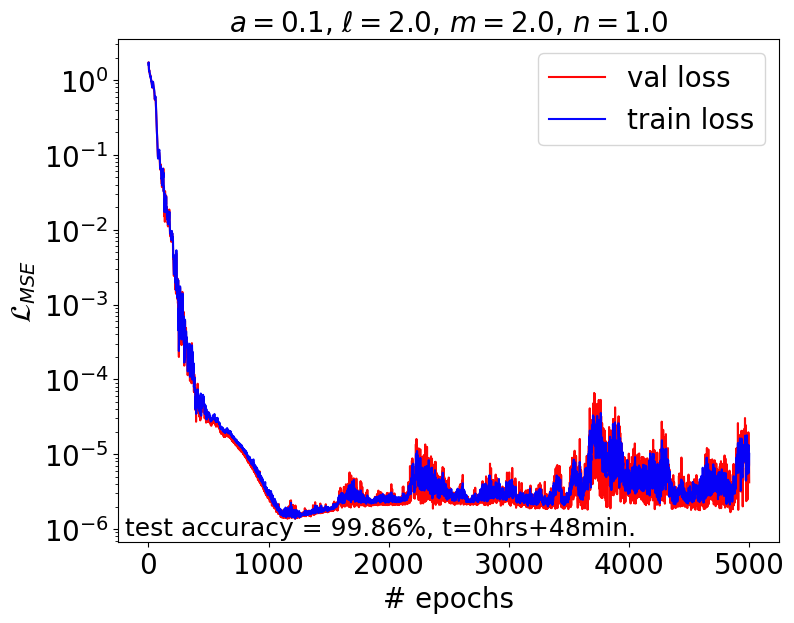

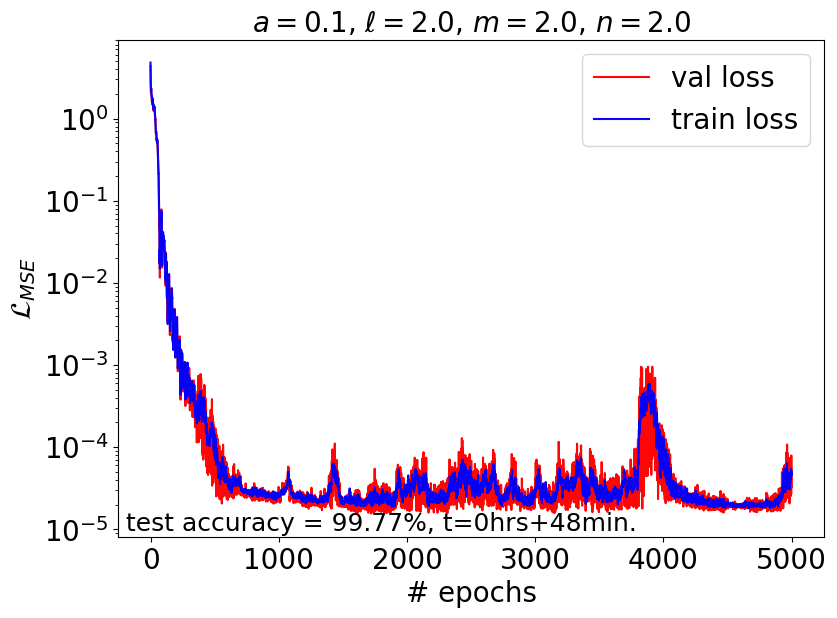

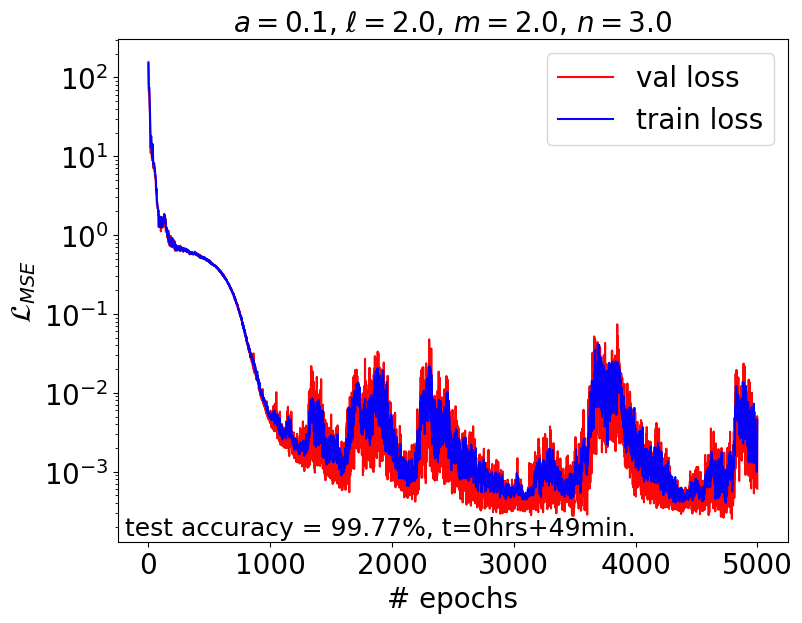

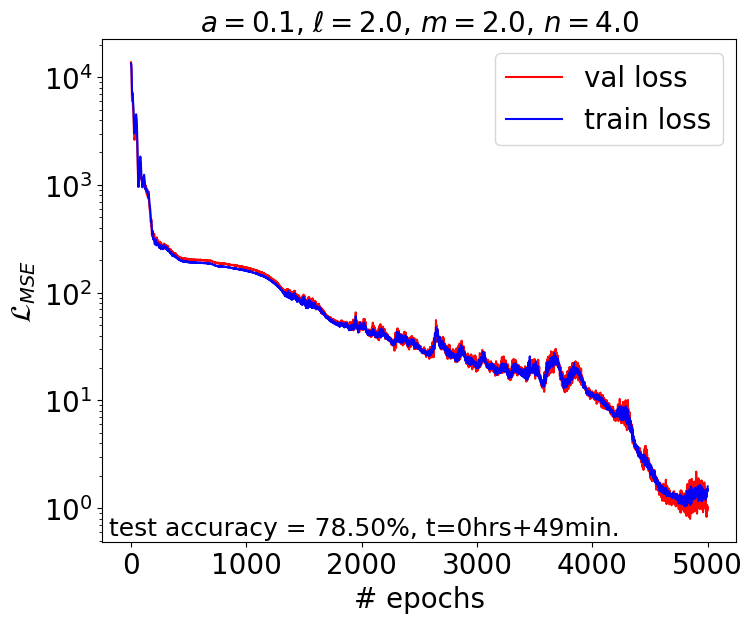

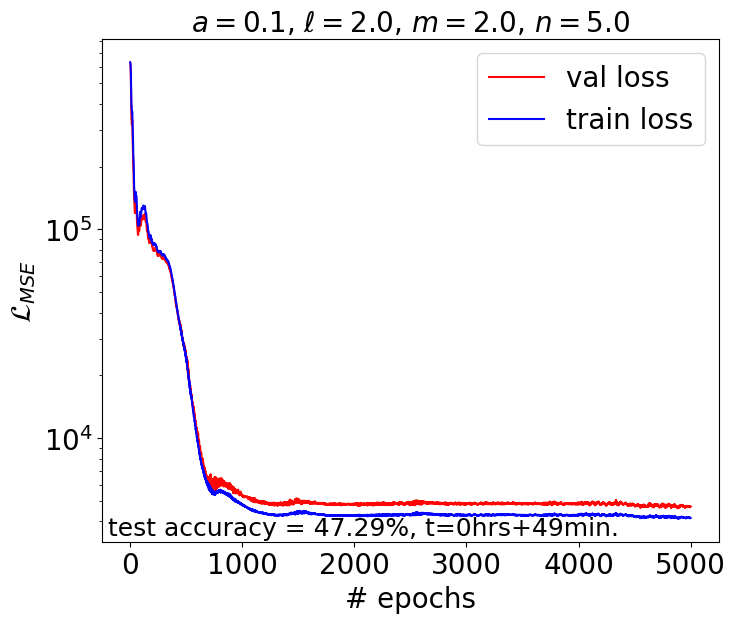

In [19]:
plot_loss_history(train_loss_dict,
                  val_loss_dict,
                  acc_dict,
                  runtime_dict, size = 20)

In [ ]:
a = [0.0]
ell = [2.0]
m = [0.0]
n = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

mode = [dict(zip(["a", "ell", "m", "n"], [i, j, k, l])) for i, j, k, l in product(a, ell, m, n)]

f1_res_dict, f2_res_dict, g1_res_dict, g2_res_dict = dict(), dict(), dict(), dict()

for i in range(len(mode)):

    a = mode[i]["a"]
    ell = mode[i]["ell"]
    m = mode[i]["m"]
    n = mode[i]["n"]

    f_res = 'RODE_a%sell%sm%sn%s.csv'%(a, ell, m, n)
    f_res = pd.read_csv('gdrive/MyDrive/qnm_data/Kerr/'+ f_res, names=["x", "f1_res", "f2_res"])

    mask1 = f_res["f1_res"] == 'Indeterminate'
    mask2 = f_res["f2_res"] == 'Indeterminate'

    f_res.loc[mask1, "f1_res"] = 10
    f_res.loc[mask2, "f2_res"] = 10

    f_res = f_res.astype('float32').to_numpy()

    g_res = 'GODE_a%sell%sm%sn%s.csv'%(a, ell, m, n)
    g_res = pd.read_csv('gdrive/MyDrive/qnm_data/Kerr/'+ g_res, names=["u", "g1_res", "g2_res"])

    mask1 = g_res["g1_res"] == 'Indeterminate'
    mask2 = g_res["g2_res"] == 'Indeterminate'

    g_res.loc[mask1, "g1_res"] = 10
    g_res.loc[mask2, "g2_res"] = 10

    g_res = g_res.astype('float32').to_numpy()

    f1_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(f_res[:, 1:2]).mean()})
    f2_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(f_res[:, 2:3]).mean()})
    g1_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(g_res[:, 1:2]).mean()})
    g2_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(g_res[:, 2:3]).mean()})


def plot_residuals_vs_overtones(f1_res_dict,
                                f2_res_dict,
                                g1_res_dict,
                                g2_res_dict,
                                size=18):

    plt.rc('xtick', labelsize=size)
    plt.rcParams.update({'font.size': size})
    plt.rc('font', size=size)
    plt.rc('axes', titlesize=size)
    plt.rc('axes', labelsize=size)
    plt.rc('legend', fontsize=size)

    n_ = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
    f1_res_, f2_res_, g1_res_, g2_res_ = [], [], [], []

    for i in n_:
        f1_res_.append(f1_res_dict["a_0.0_ell_2.0_m_0.0_n_%s" %(i)])
        f2_res_.append(f2_res_dict["a_0.0_ell_2.0_m_0.0_n_%s" %(i)])
        g1_res_.append(g1_res_dict["a_0.0_ell_2.0_m_0.0_n_%s" %(i)])
        g2_res_.append(g2_res_dict["a_0.0_ell_2.0_m_0.0_n_%s" %(i)])


    f, ax = plt.subplots(figsize = (8,6))
    plt.plot(n_, f1_res_, '-b', alpha=0.975, label="$Re[\Delta PDE(r)]$");
    plt.plot(n_, f2_res_, '-r', alpha=0.975, label="$Im[\Delta PDE(r)]$");
    f.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$\Delta PDE(r)$")
    plt.yscale("log")
    plt.legend(loc='upper left')
    xticks = [0, 1, 2, 3, 4, 5]
    xlabels = ["%s"%(x) for x in xticks]
    plt.xticks(xticks, labels=xlabels)
    plt.title("$a = 0.0$, $\ell = 2.0$, $m = 0.0$,\n $n = \{0, 1, 2, 3, 4, 5 \}$")
    plt.savefig('deltaradialpdeovertones.pdf', bbox_inches = 'tight')

    f, ax = plt.subplots(figsize = (8,6))
    plt.plot(n_, g1_res_, '-b', alpha=0.975, label="$Re[\Delta PDE(\\theta)]$");
    plt.plot(n_, g2_res_, '-r', alpha=0.975, label="$Im[\Delta PDE(\\theta)]$");
    f.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$\Delta PDE(\\theta)$")
    plt.ylim(-2e-15, 2e-15)
    plt.legend(loc='upper left')
    xticks = [0, 1, 2, 3, 4, 5]
    xlabels = ["%s"%(x) for x in xticks]
    plt.xticks(xticks, labels=xlabels)
    plt.title("$a = 0.0$, $\ell = 2.0$, $m = 0.0$,\n $n = \{0, 1, 2, 3, 4, 5 \}$")
    plt.savefig('deltaangularpdeovertones.pdf', bbox_inches = 'tight')


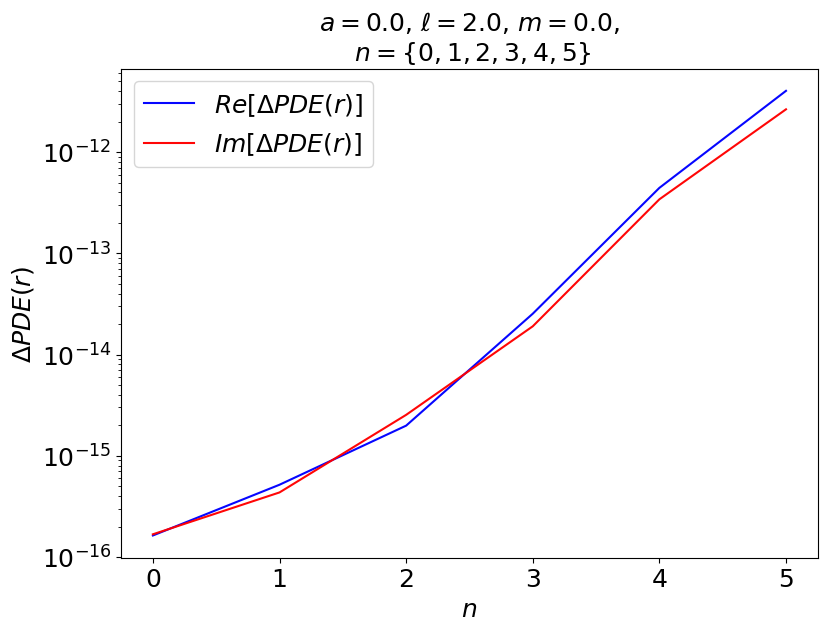

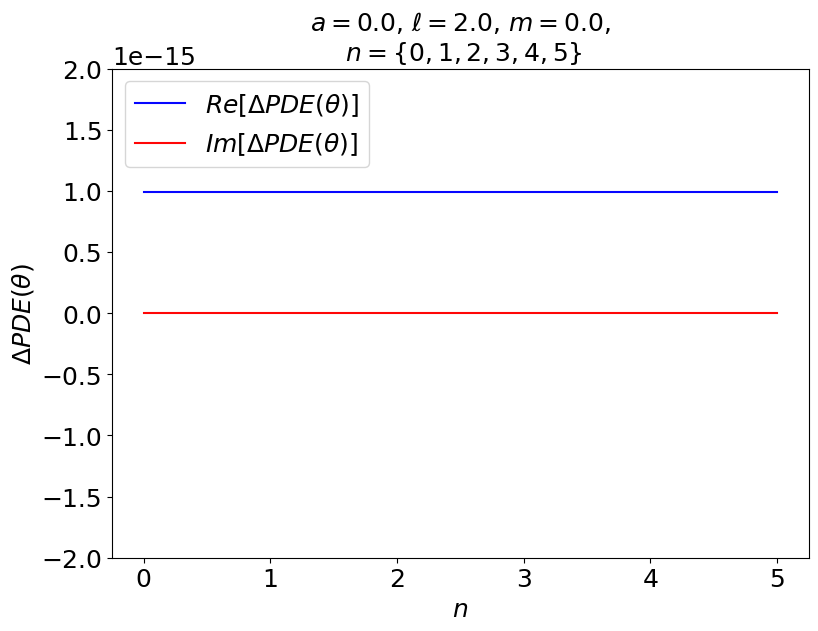

In [ ]:
plot_residuals_vs_overtones(f1_res_dict,
                            f2_res_dict,
                            g1_res_dict,
                            g2_res_dict,
                            size=18)

# extra plots

In [ ]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# just a excessively big function for adding arrows to the curve :)
def add_arrow_to_line2D(
    axes, line, arrow_locs=[0.2, 0.4, 0.6, 0.8],
    arrowstyle='-|>', arrowsize=2, transform=None):
    """
    Add arrows to a matplotlib.lines.Line2D at selected locations.

    Parameters:
    -----------
    axes:
    line: Line2D object as returned by plot command
    arrow_locs: list of locations where to insert arrows, % of total length
    arrowstyle: style of the arrow
    arrowsize: size of the arrow
    transform: a matplotlib transform instance, default to data coordinates

    Returns:
    --------
    arrows: list of arrows
    """
    if not isinstance(line, mlines.Line2D):
        raise ValueError("expected a matplotlib.lines.Line2D object")
    x, y = line.get_xdata(), line.get_ydata()

    arrow_kw = {
        "arrowstyle": arrowstyle,
        "mutation_scale": 10 * arrowsize,
    }

    color = line.get_color()
    use_multicolor_lines = isinstance(color, np.ndarray)
    if use_multicolor_lines:
        raise NotImplementedError("multicolor lines not supported")
    else:
        arrow_kw['color'] = color

    linewidth = line.get_linewidth()
    if isinstance(linewidth, np.ndarray):
        raise NotImplementedError("multiwidth lines not supported")
    else:
        arrow_kw['linewidth'] = linewidth

    if transform is None:
        transform = axes.transData

    arrows = []
    for loc in arrow_locs:
        s = np.cumsum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))
        n = np.searchsorted(s, s[-1] * loc)
        arrow_tail = (x[n], y[n])
        arrow_head = (np.mean(x[n:n + 2]), np.mean(y[n:n + 2]))
        p = mpatches.FancyArrowPatch(
            arrow_tail, arrow_head, transform=transform,
            **arrow_kw)
        axes.add_patch(p)
        arrows.append(p)
    return arrows

def kerr_2Dplots(omega1, err1, omega2, err2, A1, err3, A2, err4, omega, A, a, ell, m, n, runtime):

  size = 15
  plt.rc('xtick', labelsize=16)
  plt.rcParams.update({'font.size': 16})
  plt.rc('font', size=size)
  plt.rc('axes', titlesize=size)
  plt.rc('axes', labelsize=size)
  plt.rc('legend', fontsize=size)
  plt.rcParams['legend.loc'] = "upper right"

  # plots for the quasinormal mode frequencies

  f, ax = plt.subplots(figsize = (8,6))

  if omega1[-1] > 0 and omega2[-1] > 0:
    line1, = plt.plot(np.array(omega2)*(-1), np.array(omega1)*(1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(1)) + 0.25)

  elif omega1[-1] < 0 and omega2[-1] < 0:
    line1, = plt.plot(np.array(omega2), np.array(omega1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(-1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(-1)) + 0.25)

  elif omega1[-1] < 0 and omega2[-1] > 0:
    line1, = plt.plot(np.array(omega2)*(-1), np.array(omega1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(-1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(-1)) + 0.25)

  elif omega1[-1] > 0 and omega2[-1] < 0:
    line1, = plt.plot(np.array(omega2)*(1), np.array(omega1)*(1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(1)) + 0.25)

  plt.scatter(omega.imag, omega.real, c="r", alpha=1, marker=r'x', label = 'CFM: $\omega_{n}$ = %.6f - %.6fj' %(abs(omega.real), abs(omega.imag)), zorder=2)

  plt.legend()
  text = 's. PINN: $\omega_{n}$ = %.6f - %.6fj (%.3f%%, %.3f%%)\n runtime %.1f minutes' %(abs(omega1[-1]), abs(omega2[-1]), err1[-1], err2[-1], round(runtime/60))
  plt.text(.01, .1, text, size= 14, ha='left', va='top', transform=ax.transAxes)
  plt.title("$s$=-2, $a$={}, $\ell$={}, $m$={}, $n$={}".format(a, ell, m, n))
  plt.ylabel('Re[$\omega_{n}$]');plt.xlabel('Im[$\omega_{n}$]')
  plt.savefig("omega_s-2.0_a{}_ell{}_m{}_n{}.pdf".format(a, ell, m, n), bbox_inches='tight')

  # plots for the separation constants

  f, ax = plt.subplots(figsize = (8,6))

  if A1[-1] > 0 and A2[-1] > 0:
    line, = plt.plot(np.array(A2), np.array(A1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)) - 0.5)
    plt.plot(0, max(np.array(A1)) + 0.5)

  elif A1[-1] < 0 and A2[-1] < 0:
    line, = plt.plot(np.array(A2)*(-1), np.array(A1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)*(-1)) - 0.5)
    plt.plot(0, max(np.array(A1)*(-1)) + 0.5)

  elif A1[-1] < 0 and A2[-1] > 0:
    line, = plt.plot(np.array(A2), np.array(A1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)*(-1)) - 0.5)
    plt.plot(0, max(np.array(A1)*(-1)) + 0.5)

  elif A1[-1] > 0 and A2[-1] < 0:
    line, = plt.plot(np.array(A2)*(-1), np.array(A1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)) - 0.5)
    plt.plot(0, max(np.array(A1)) + 0.5)


  plt.scatter(A.imag, A.real, c="r", alpha=1, marker=r'x', label = 'CFM: $A_{\ell m}$ = %.6f + %.6fj' %(abs(A.real), abs(A.imag)), zorder=2)

  plt.legend()
  text = 'PINN: $A_{\ell m}$ = %.6f + %.6fj (%.3f%%, %.3f%%)\n runtime %.1f minutes' %(abs(A1[-1]), abs(A2[-1]), err3[-1], err4[-1], round(runtime/60))
  plt.text(.01, .1, text, size= 14, ha='left', va='top', transform=ax.transAxes)
  plt.title("$s$=-2, $a$={}, $\ell$={}, $m$={}, $n$={}".format(a, ell, m, n))
  plt.ylabel('Re[$A_{\ell m}$]');plt.xlabel('Im[$A_{\ell m}$]')
  plt.savefig("A_s-2.0_a{}_ell{}_m{}_n{}.pdf".format(a, ell, m, n), bbox_inches='tight')

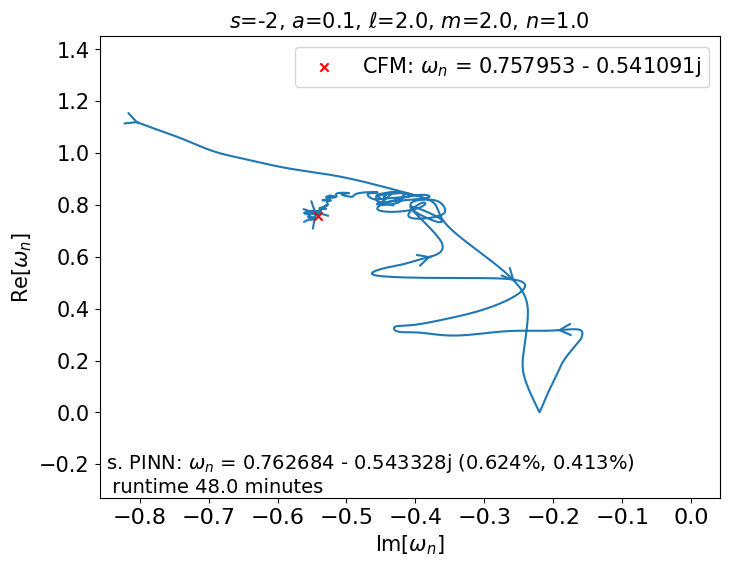

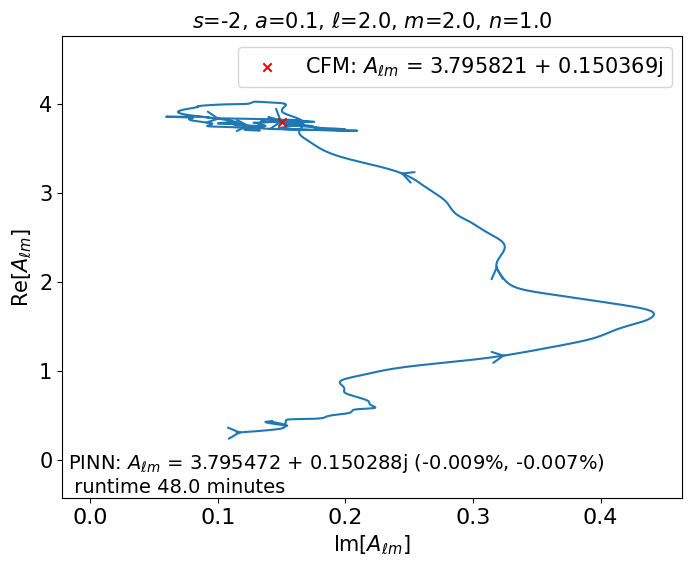

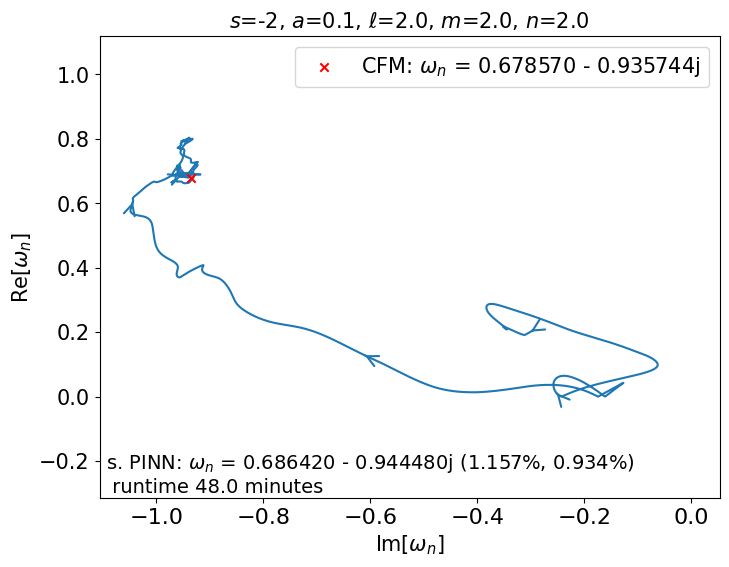

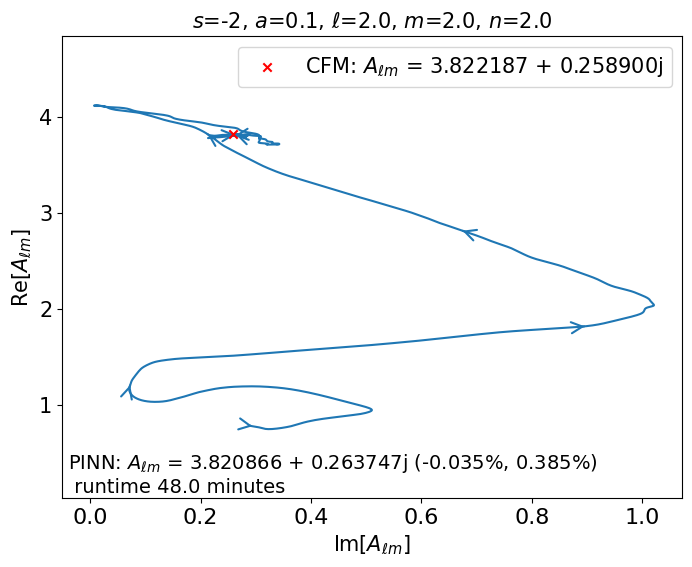

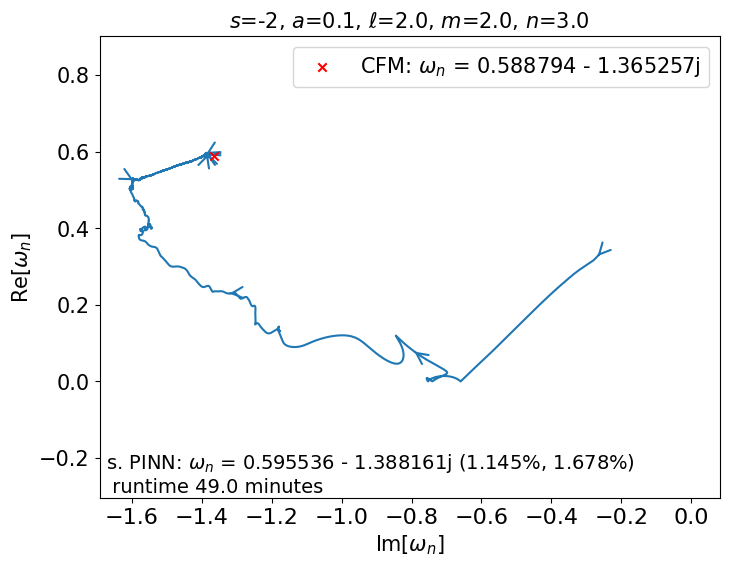

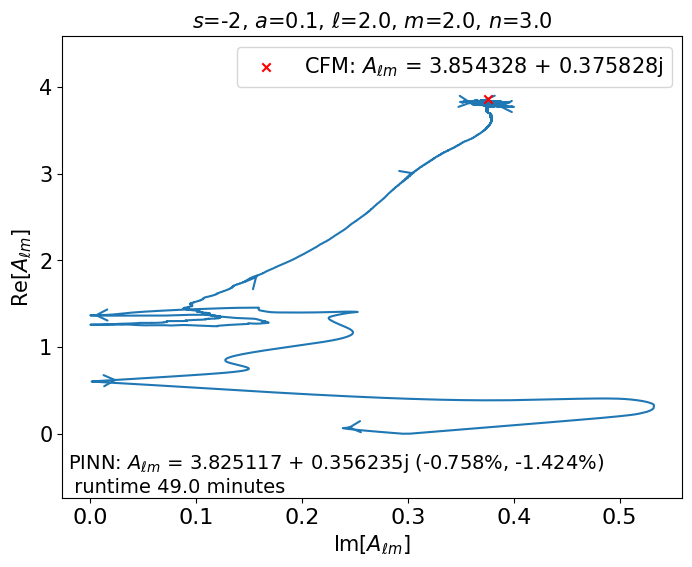

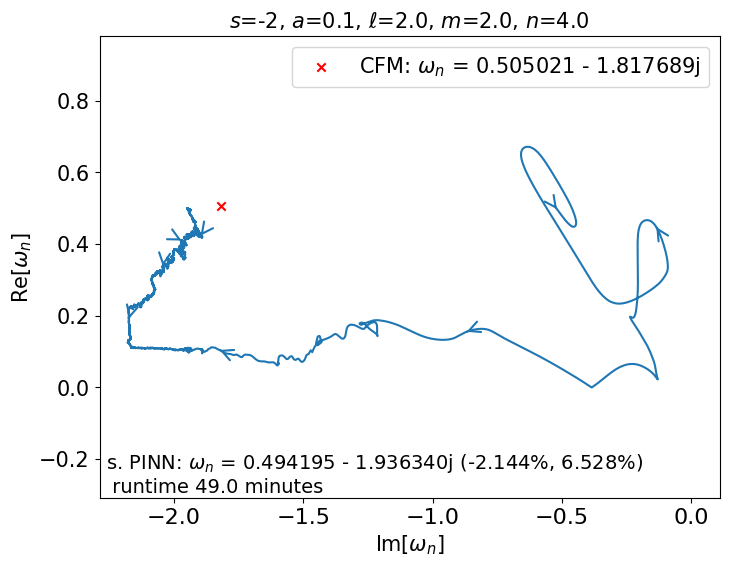

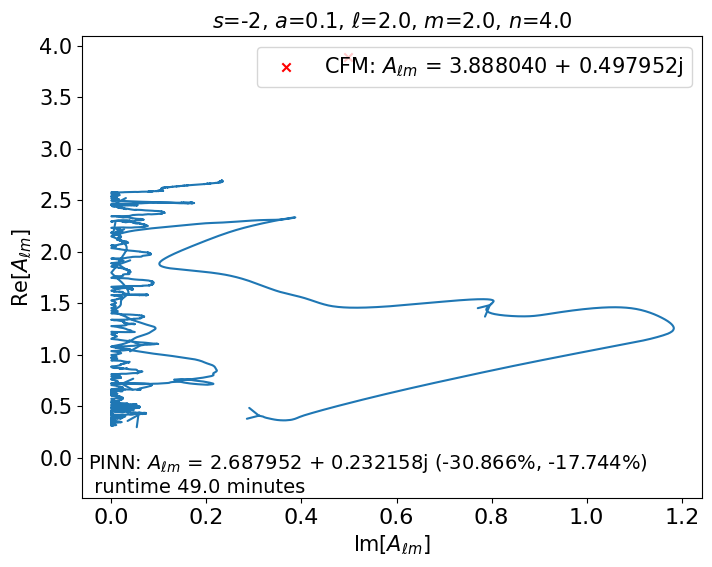

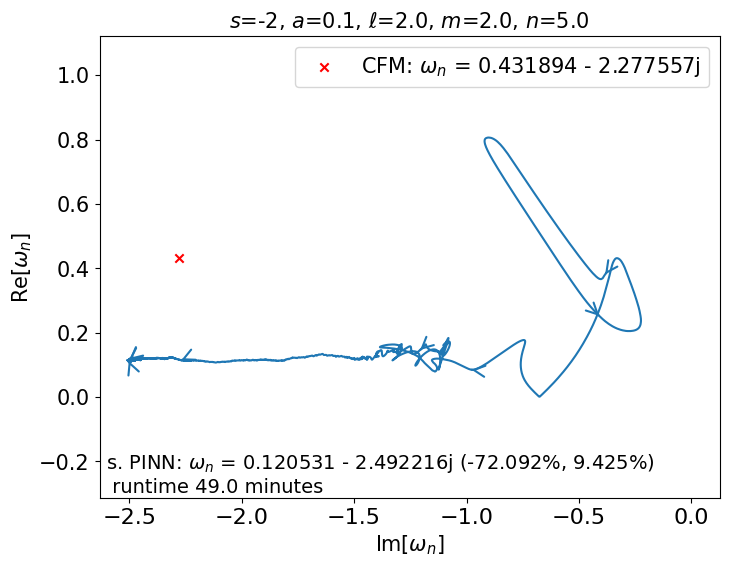

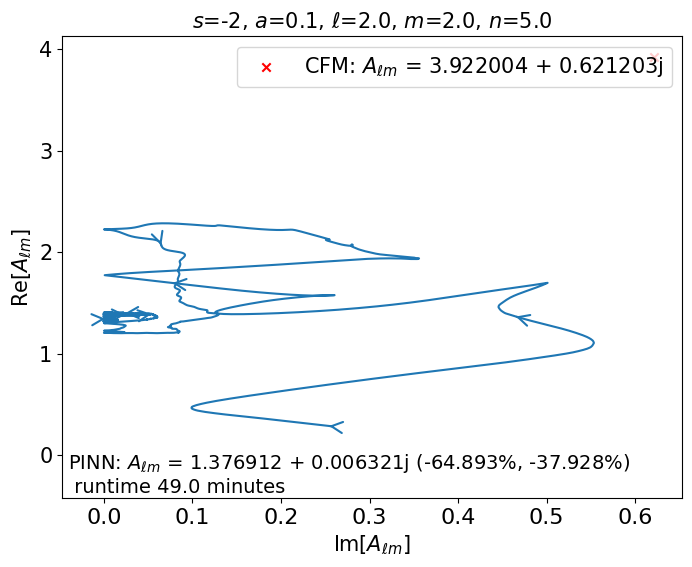

In [20]:
s = -2
a = [0.1]
ell = [2.0]
m = [2.0]
n = [1.0, 2.0, 3.0, 4.0, 5.0]

mode = [dict(zip(["a", "ell", "m", "n"], [i, j, k, l])) for i, j, k, l in product(a, ell, m, n)]

for i in range(len(mode)):

    s = -2
    a = mode[i]["a"]
    ell = mode[i]["ell"]
    m = mode[i]["m"]
    n = mode[i]["n"]

    spin_sequence_slmn = qnm.modes_cache(s=int(s), l=int(ell), m=int(m), n=int(n))
    omega_, A_, _ = spin_sequence_slmn(a=a*2)

    kerr_2Dplots(
    omega1_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err1_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    omega2_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err2_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    A1_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err3_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    A2_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err4_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    omega_*2,
    A_,
    a, ell, m, n,
    runtime_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)])